# F356w

Images oversemplé d'un facteur 2 par rapport à la psf

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pycolfits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm.notebook import trange
from copy import deepcopy
from  matplotlib.colors import LogNorm

In [2]:
def flag_results(data):
    flag_nan, = np.where((np.isnan(data['SERSIC_GALFIT'])) | (np.isnan(data['ARERR_GALFIT'])) | (np.isnan(data['ELLIPTICITYERR_GALFIT']))
                         |(np.isnan(data['SERSICERR_GALFIT'])) | (np.isnan(data['REERR_GALFIT'])) | (np.isnan(data['MAGERR_GALFIT'])))
    mask_nan=np.ones(len(data['FIT_DONE']),bool)
    mask_nan[flag_nan]=0
    flag_all,=np.where(mask_nan==True)
    flag_bad,=np.where((data['SERSIC_GALFIT']==0.2) | (data['SERSIC_GALFIT']==20.) | (data['REERR_GALFIT']==99999) | (data['RE_GALFIT']==400) )
    mask_bad=np.ones(len(data['FIT_DONE']),bool)
    mask_bad[flag_bad]=0
    flag_good,=np.where(data['FLAGS_GALFIT']=='GOOD')
    mask_good=np.ones(len(data['FIT_DONE']),bool)
    mask_good[flag_good]=0
    mask_bad_nan=mask_bad&mask_nan
    flag_all_m_b, = np.where(mask_bad_nan==True)
    
    good,=np.where((mask_bad&mask_nan&np.logical_not(mask_good))==True)
    suspisious,=np.where((mask_bad&mask_nan&mask_good)==True)
    bad,=np.where((np.logical_not(mask_bad)&mask_nan)==True)
    non_exist,=np.where(np.logical_not(mask_nan))
    return good, suspisious, bad, non_exist

In [3]:
def flag_results_m80(data,mag80):
    flag_nan, = np.where((np.isnan(data['SERSIC_GALFIT'])) | (np.isnan(data['ELLIPTICITYERR_GALFIT'])) | (np.isnan(data['ARERR_GALFIT'])) 
                         | (np.isnan(data['SERSICERR_GALFIT'])) | (np.isnan(data['REERR_GALFIT'])) | (np.isnan(data['MAGERR_GALFIT'])))
    mask_nan=np.ones(len(data['FIT_DONE']),bool)
    mask_nan[flag_nan]=0
    flag_all,=np.where(mask_nan==True)
    flag_bad,=np.where((data['SERSIC_GALFIT']==0.2) | (data['SERSIC_GALFIT']==20.) | (data['REERR_GALFIT']==99999) | (data['RE_GALFIT']==400) | (data['MAG_BEST']>mag80) )
    mask_bad=np.ones(len(data['FIT_DONE']),bool)
    mask_bad[flag_bad]=0
    flag_good,=np.where(data['FLAGS_GALFIT']=='GOOD')
    mask_good=np.ones(len(data['FIT_DONE']),bool)
    mask_good[flag_good]=0
    mask_bad_nan=mask_bad&mask_nan
    flag_all_m_b, = np.where(mask_bad_nan==True)
    
    good,=np.where((mask_bad&mask_nan&np.logical_not(mask_good))==True)
    suspisious,=np.where((mask_bad&mask_nan&mask_good)==True)
    bad,=np.where((np.logical_not(mask_bad)&mask_nan)==True)
    non_exist,=np.where(np.logical_not(mask_nan))
    return good, suspisious, bad, non_exist

In [4]:
%matplotlib inline

# Image disk

## catalogue 

In [5]:
disk = fits.open("combcat356_disk_final.fits")
data_disk=disk[1].data
hdu_disk=disk[1].header

In [6]:
print("Nombres de galaxies fité par GALFIT :",data_disk['FIT_DONE'].shape[0])

Nombres de galaxies fité par GALFIT : 17426


In [8]:
good, suspisious, bad, non_exist = flag_results(data_disk)

gs=np.concatenate((good,suspisious))
bn=np.concatenate((bad,non_exist))

In [8]:
good, suspisious, bad, non_exist = flag_results_m80(data_disk,27.7)

gs=np.concatenate((good,suspisious))
bn=np.concatenate((bad,non_exist))

In [8]:
good.shape[0]+suspisious.shape[0]+bad.shape[0]+non_exist.shape[0]

17426

In [9]:
print("nombre de galaxies utilisable :",good.shape[0]+suspisious.shape[0], ", c'est-à-dire", good.shape[0], "good et",suspisious.shape[0],"suspect")

nombre de galaxies utilisable : 10705 , c'est-à-dire 5546 good et 5159 suspect


In [10]:
print("good : ",good.shape[0]/data_disk['FIT_DONE'].shape[0], "\nsuspisious : ",suspisious.shape[0]/data_disk['FIT_DONE'].shape[0],"\nbad :",bad.shape[0]/data_disk['FIT_DONE'].shape[0],"\nfail : ",non_exist.shape[0]/data_disk['FIT_DONE'].shape[0])

good :  0.3182600711580397 
suspisious :  0.29605187650636977 
bad : 0.0981866176976931 
fail :  0.2875014346378974


In [11]:
print("good : ",gs.shape[0]/data_disk['FIT_DONE'].shape[0], "\nbad : ",bn.shape[0]/data_disk['FIT_DONE'].shape[0])

good :  0.6143119476644096 
bad :  0.3856880523355905


## Positions des flag sur l'image

In [12]:
img=fits.open("/local/home/fs269899/stage/egg_jwst/PRIMER/NIRCam/f356w/egg-20220325-jwst-f356w-sci_2_disk_adu.fits")
img_disk=img[0].data
header_disk=img[0].header

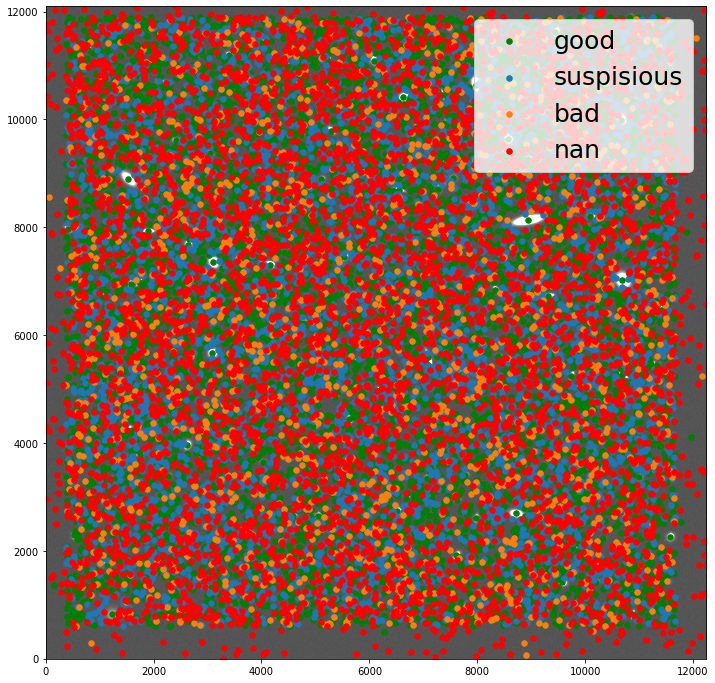

In [17]:
norm = ImageNormalize(img_disk, interval=ZScaleInterval())
%matplotlib inline
plt.figure(figsize=(12,12))
plt.imshow(img_disk, cmap='gray', norm=norm, origin='lower')
plt.scatter(data_disk['X_IMAGE'][good]-1,data_disk['Y_IMAGE'][good]-1,s=30,c='g', label='good')
plt.scatter(data_disk['X_IMAGE'][suspisious]-1,data_disk['Y_IMAGE'][suspisious]-1,s=30,label='suspisious')
plt.scatter(data_disk['X_IMAGE'][bad]-1,data_disk['Y_IMAGE'][bad]-1,s=30,label='bad')
plt.scatter(data_disk['X_IMAGE'][non_exist]-1,data_disk['Y_IMAGE'][non_exist]-1,s=30,c='r',label='nan')
plt.legend(loc='upper right',fontsize=25)
plt.show()

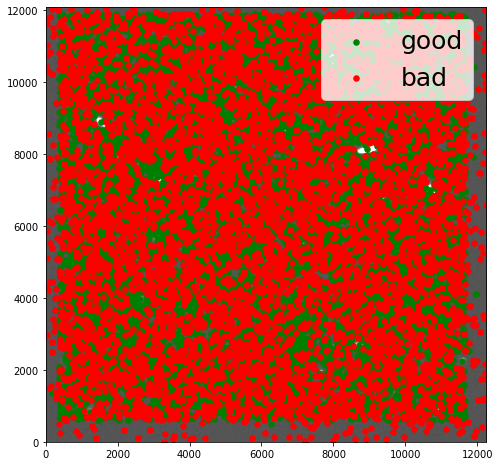

In [17]:
norm = ImageNormalize(img_disk, interval=ZScaleInterval())
%matplotlib inline
plt.figure(figsize=(8,8))
plt.imshow(img_disk, cmap='gray', norm=norm, origin='lower')
plt.scatter(data_disk['X_IMAGE'][gs]-1,data_disk['Y_IMAGE'][gs]-1,s=30,c='g', label='good')
plt.scatter(data_disk['X_IMAGE'][bn]-1,data_disk['Y_IMAGE'][bn]-1,s=30,c='r',label='bad')
plt.legend(loc='upper right',fontsize=25)
plt.show()

In [26]:
%matplotlib inline

## Mag 

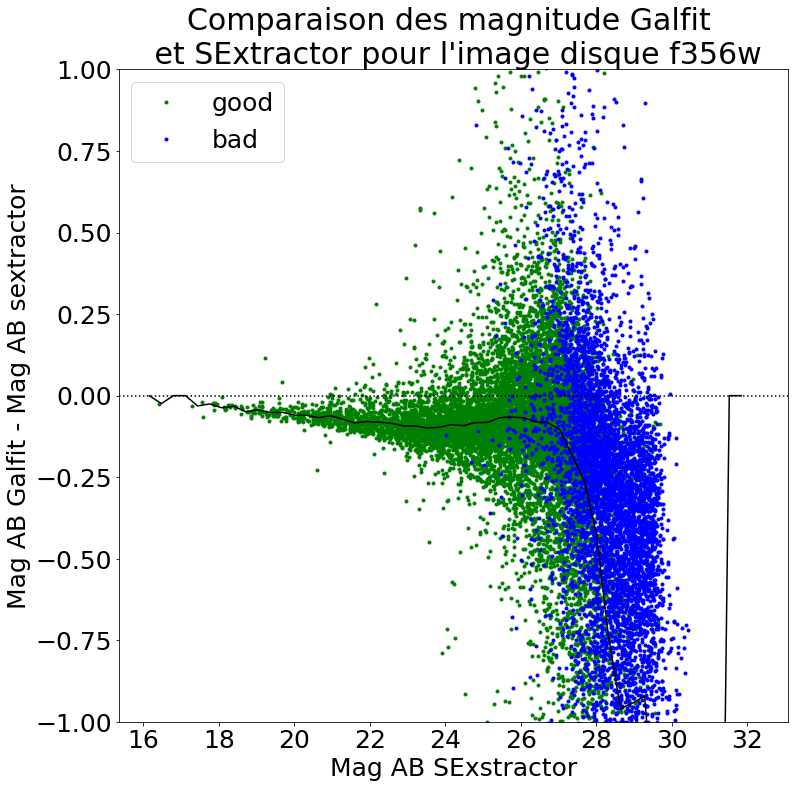

In [41]:
mag_med= []
mag_m=[]

bx=50

f=[gs,bn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    #dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(data_disk['MAG_BEST'][f[i]].min())+( int(data_disk['MAG_BEST'][f[i]].max()+1)-int(data_disk['MAG_BEST'][f[i]].min())  )/bx*j
        maxx= int(data_disk['MAG_BEST'][f[i]].min())+( int(data_disk['MAG_BEST'][f[i]].max()+1)-int(data_disk['MAG_BEST'][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((data_disk['MAG_BEST'][f[i]]>minx) & (data_disk['MAG_BEST'][f[i]]<maxx))
        
        if len(data_disk['MAG_GALFIT'][f[i]][m_index]-data_disk['MAG_BEST'][f[i]][m_index]) >=1 :
            r.append(np.median(((data_disk['MAG_GALFIT'][f[i]][m_index]-data_disk['MAG_BEST'][f[i]][m_index]))))
        else :
            r.append(0)
        ml.append((minx+maxx)/2)
    
    mag_med.append(r)
    
    mag_m.append(ml)
    
plt.figure(figsize=(12,12))
plt.plot(data_disk['MAG_BEST'][gs],data_disk['MAG_GALFIT'][gs]-data_disk['MAG_BEST'][gs],'g.',label="good")
plt.plot(data_disk['MAG_BEST'][bn],data_disk['MAG_GALFIT'][bn]-data_disk['MAG_BEST'][bn],'b.',label="bad")
plt.plot(mag_m[0],mag_med[0],'k')
plt.axhline(y=0,color='k',linestyle=':')
plt.xlabel('Mag AB SExstractor',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB sextractor', fontsize=25)
plt.title("Comparaison des magnitude Galfit \n et SExtractor pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(-1,1)
plt.legend(fontsize=25)
plt.show()

/tmp/ipykernel_79554/3149164629.py:13: RuntimeWarning: invalid value encountered in true_divide
  pg = a[0]/b[0]


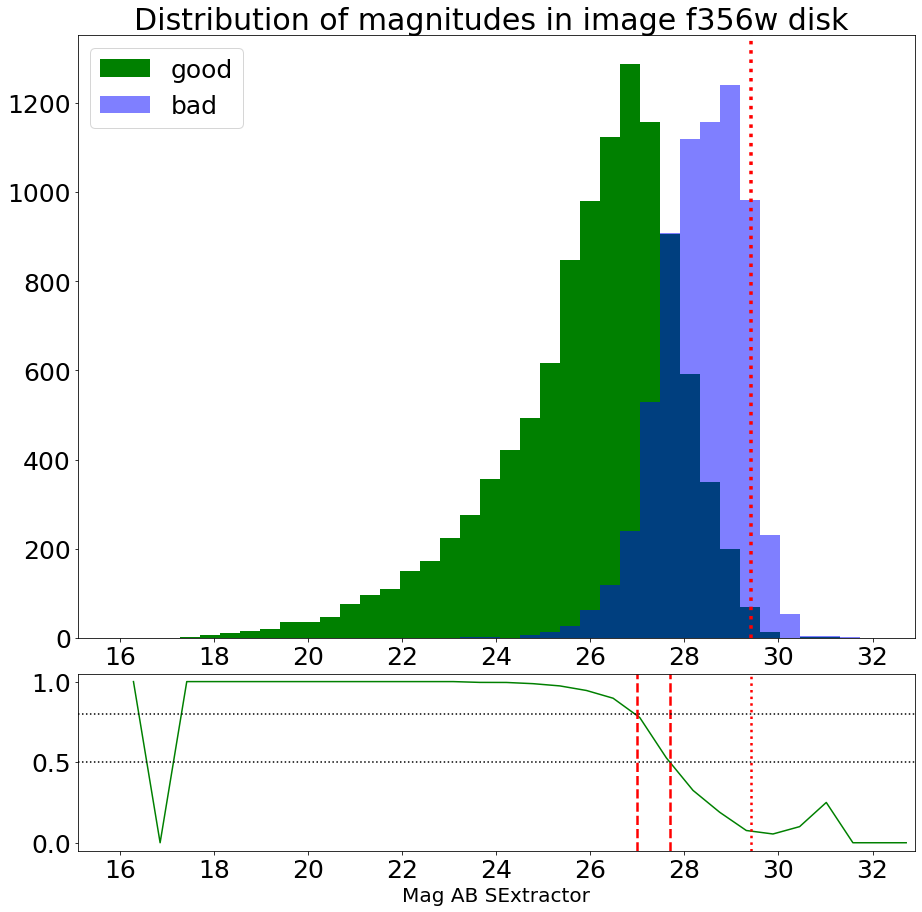

In [16]:
fig=plt.figure(figsize=(15,15))
axes=fig.subplot_mosaic(
    """
    fff
    fff
    fff
    ppp

    """)

a=np.histogram(data_disk['MAG_BEST'][gs],range=(16,33),bins=30)
b=np.histogram(data_disk['MAG_BEST'],bins=a[1])
pg = a[0]/b[0]
pg[np.isnan(pg)]=0
pos=[]
for i in range(len(a[0])):
    pos.append((a[1][i]+a[1][i+1])/2)

axes['f'].hist(data_disk['MAG_BEST'][gs],range=(16,33),color='g',bins=40,label="good",density=False)
axes['f'].hist(data_disk['MAG_BEST'][bn],range=(16,33),color='b',alpha=0.5,bins=40,label='bad',density=False)
axes['f'].axvline(x=29.42,color='r',linestyle=':', linewidth=3.5)
axes['f'].legend(fontsize=25)
axes['f'].tick_params(axis='both', labelsize=25)
axes['f'].set_xlim(15.1,32.9)
axes['f'].set_title("Distribution of magnitudes in image f356w disk ",fontsize=30)

axes['p'].plot(pos,pg,"g")
axes['p'].axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
axes['p'].axvline(x=27.7,color='r',linestyle='--', linewidth=2.5)
axes['p'].axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)
axes['p'].axhline(y=0.5,color='k',linestyle=':', linewidth=1.5)
axes['p'].axhline(y=0.8,color='k',linestyle=':', linewidth=1.5)
axes['p'].tick_params(axis='both', labelsize=25)
axes['p'].set_xlabel("Mag AB SExtractor",fontsize=20)
axes['p'].set_xlim(15.1,32.9)

plt.show()

## Sersic 

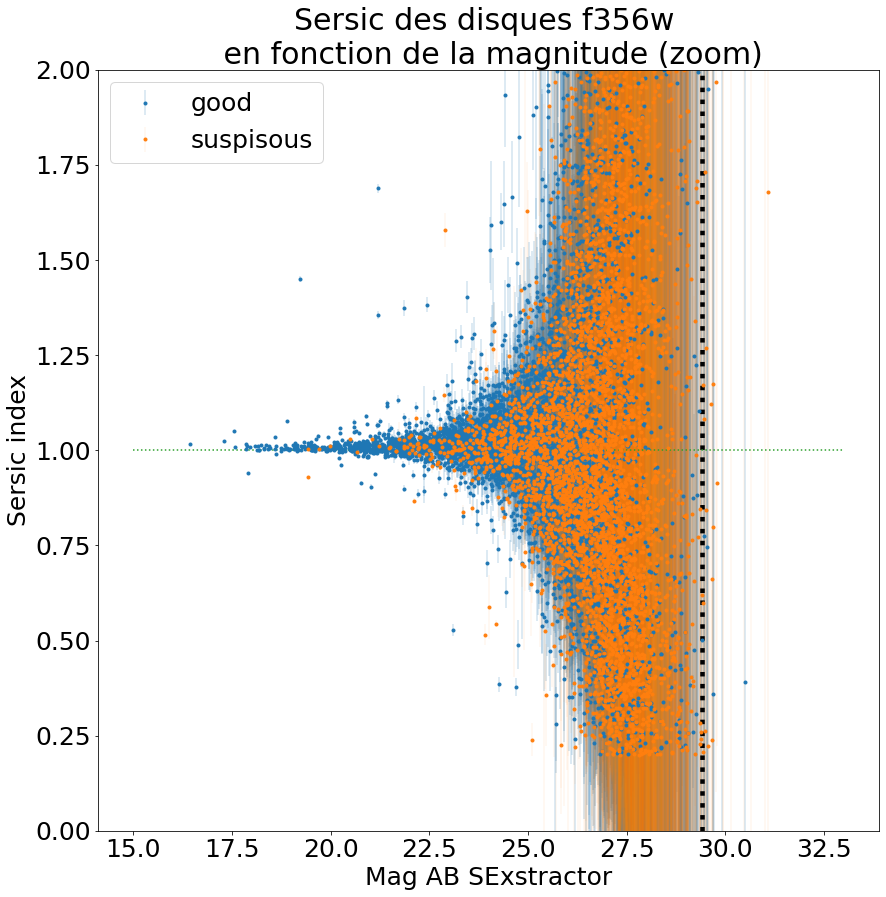

In [20]:
plt.figure(figsize=(14,14))
#plt.errorbar(data_disk['MAG_BEST'],data_disk['SERSIC_GALFIT'],yerr=data_disk['SERSICERR_GALFIT'],fmt='k.',elinewidth=0.3,label='other')
plt.errorbar(data_disk['MAG_BEST'][good],data_disk['SERSIC_GALFIT'][good],yerr=data_disk['SERSICERR_GALFIT'][good],fmt='.',elinewidth=0.3,label='good')
plt.errorbar(data_disk['MAG_BEST'][suspisious],data_disk['SERSIC_GALFIT'][suspisious],yerr=data_disk['SERSICERR_GALFIT'][suspisious],fmt='.',elinewidth=0.1,label='suspisous')
plt.xlabel('Mag AB SExstractor',fontsize=25)
plt.ylabel('Sersic index', fontsize=25)
plt.title('Sersic des disques f356w \n en fonction de la magnitude (zoom)', fontsize=30)
#plt.xlim(16.5,30)
plt.xticks(fontsize=25)
plt.ylim(0,2)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=4.5)
plt.plot(np.arange(15,35,3),np.ones(np.arange(15,35,3).shape[0]),":")
plt.show()

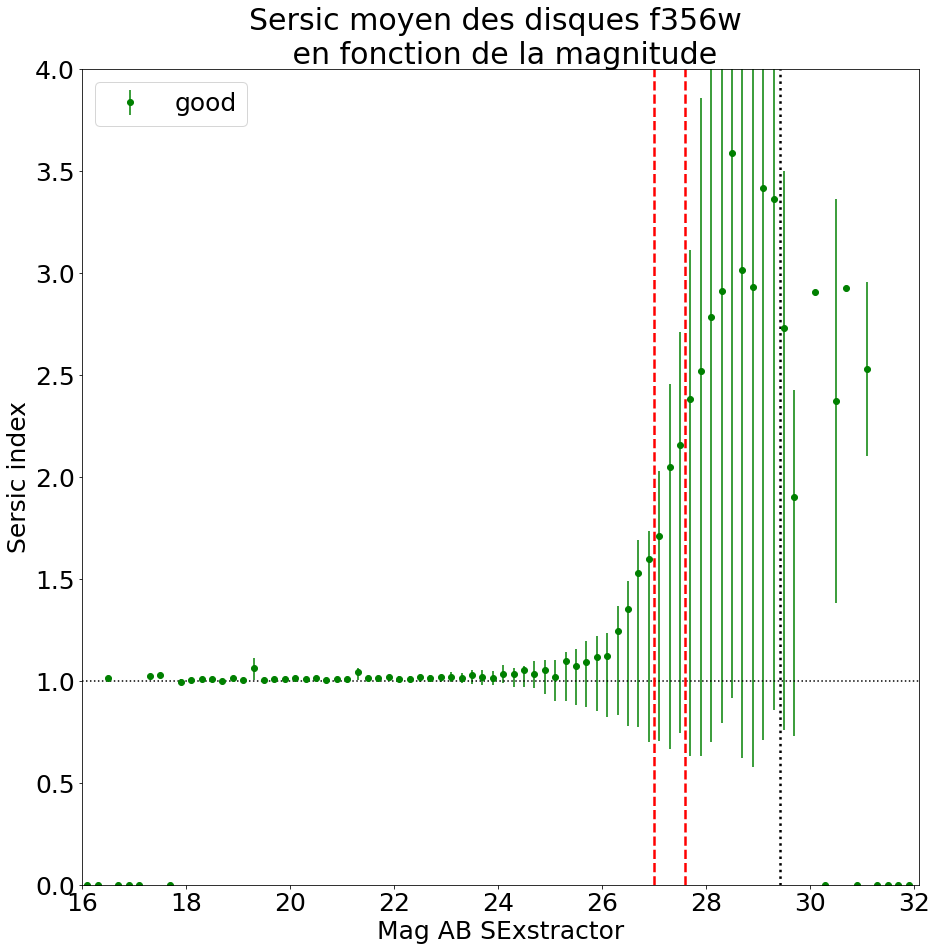

In [48]:
sersic = []
low_err, high_err = [],[]
mag=[]

bx=80

m_min = data_disk['MAG_BEST'][gs].min()
m_max = data_disk['MAG_BEST'][gs].max()
for j in range(bx) :
    
    minx= int(data_disk['MAG_BEST'][gs].min())+( int(data_disk['MAG_BEST'][gs].max()+1)-int(data_disk['MAG_BEST'][gs].min())  )/bx*j
    maxx= int(data_disk['MAG_BEST'][gs].min())+( int(data_disk['MAG_BEST'][gs].max()+1)-int(data_disk['MAG_BEST'][gs].min())  )/bx*(j+1)
    
    m_index,=np.where((data_disk['MAG_BEST'][gs]>minx) & (data_disk['MAG_BEST'][gs]<maxx))
    
    if data_disk['SERSIC_GALFIT'][gs][m_index].shape[0]>=1 : 
        sersic.append(np.mean(data_disk['SERSIC_GALFIT'][gs][m_index]))
        low_err.append(abs(np.mean(data_disk['SERSIC_GALFIT'][gs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][gs][m_index],0.25)))
        high_err.append(abs(np.mean(data_disk['SERSIC_GALFIT'][gs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][gs][m_index],0.75)))
        
    else :
        sersic.append(0)
        low_err.append(0)
        high_err.append(0)
        
    mag.append((minx+maxx)/2)
        

errg = [low_err,high_err]

%matplotlib inline
plt.figure(figsize=(15,15))
plt.errorbar(mag,sersic,yerr=errg,fmt="o",color='g',label="good")
plt.plot(np.arange(16,35,3),np.ones(np.arange(16,35,3).shape[0]),"k:")
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)
#plt.errorbar(m_b,s_b,yerr=d_sersic_b,fmt=".",label="bad")
plt.xlabel('Mag AB SExstractor',fontsize=25)
plt.ylabel('Sersic index', fontsize=25)
plt.title('Sersic moyen des disques f356w \n en fonction de la magnitude', fontsize=30)
plt.xlim(16,32.1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylim(0,4)
plt.show()

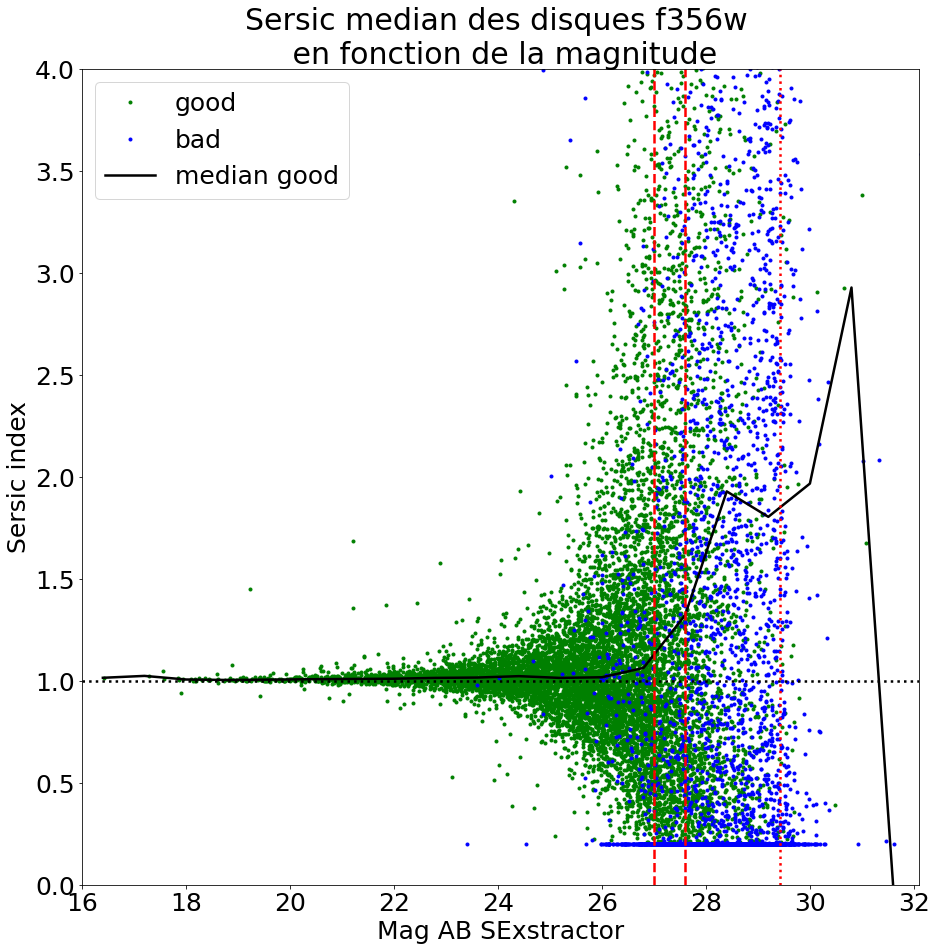

In [16]:
%matplotlib inline

sersic = []
low_err, high_err = [],[]
mag=[]

bx=20

m_min = data_disk['MAG_BEST'][gs].min()
m_max = data_disk['MAG_BEST'][gs].max()
for j in range(bx) :
    
    minx= int(data_disk['MAG_BEST'][gs].min())+( int(data_disk['MAG_BEST'][gs].max()+1)-int(data_disk['MAG_BEST'][gs].min())  )/bx*j
    maxx= int(data_disk['MAG_BEST'][gs].min())+( int(data_disk['MAG_BEST'][gs].max()+1)-int(data_disk['MAG_BEST'][gs].min())  )/bx*(j+1)
    
    m_index,=np.where((data_disk['MAG_BEST'][gs]>minx) & (data_disk['MAG_BEST'][gs]<maxx))
    
    if data_disk['SERSIC_GALFIT'][gs][m_index].shape[0]>=1 : 
        sersic.append(np.median(data_disk['SERSIC_GALFIT'][gs][m_index]))
        low_err.append(abs(np.median(data_disk['SERSIC_GALFIT'][gs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][gs][m_index],0.25)))
        high_err.append(abs(np.median(data_disk['SERSIC_GALFIT'][gs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][gs][m_index],0.75)))
        
    else :
        sersic.append(0)
        low_err.append(0)
        high_err.append(0)
        
    mag.append((minx+maxx)/2)
        

errg = [low_err,high_err]

plt.figure(figsize=(15,15))
plt.plot(data_disk['MAG_BEST'][gs],data_disk['SERSIC_GALFIT'][gs],'g.',label='good')
plt.plot(data_disk['MAG_BEST'][bn],data_disk['SERSIC_GALFIT'][bn],'b.',label='bad')
#plt.errorbar(mag,sersic,yerr=errg,fmt="-",color='k',label="mean good", linewidth=3.5)
plt.plot(mag,sersic,'k',label="median good", linewidth=2.5)

plt.axhline(y=1,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)
#plt.errorbar(m_b,s_b,yerr=d_sersic_b,fmt=".",label="bad")
plt.xlabel('Mag AB SExstractor',fontsize=25)
plt.ylabel('Sersic index', fontsize=25)
plt.title('Sersic median des disques f356w \n en fonction de la magnitude', fontsize=30)
plt.xlim(16,32.1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylim(0,4)
plt.show()

In [12]:
dn_gs = 1-data_disk['SERSIC_GALFIT'][gs]
norm_dn_gs = dn_gs/data_disk['SERSICERR_GALFIT'][gs]
norm_dn_gs[np.isinf(norm_dn_gs)]=0

n_mean=np.mean(norm_dn_gs)
n_std=np.std(norm_dn_gs)
print("mean good :",n_mean,'std good',n_std)

mean good : -0.0342533051562044 std good 100.64168594320529


/tmp/ipykernel_39081/1959660790.py:2: RuntimeWarning: divide by zero encountered in true_divide
  norm_dn_gs = dn_gs/data_disk['SERSICERR_GALFIT'][gs]


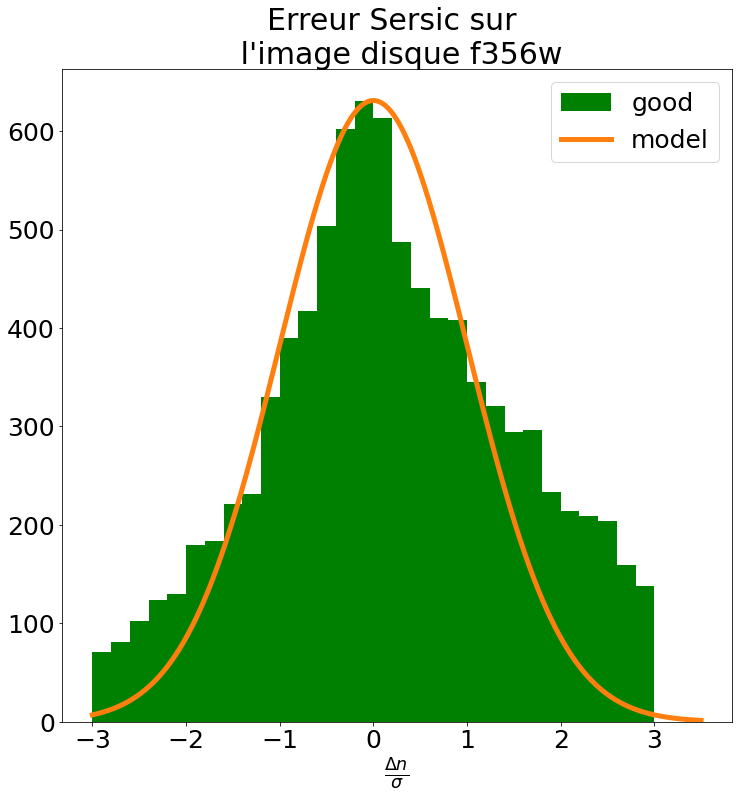

In [19]:
plt.figure(figsize=(12,12))

a=plt.hist((norm_dn_gs+0.4)*1.5,range=(-3,3),bins=30,color='g', label="good")
x=np.arange(-3,3.5,0.001)
plt.plot(x,a[0].max()*np.exp(-(x-0)**2/(2*1**2)),linewidth=5,color='tab:orange',label="model")
#plt.semilogy()
plt.xlabel(r'$\frac{\Delta n}{\sigma}$',fontsize=25)
plt.title("Erreur Sersic sur \n l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend(fontsize=25)

plt.show()

In [77]:
%matplotlib inline

## in vs out

### catalogue 

In [9]:
cat = pycolfits.readfrom('/local/home/fs269899/stage/egg_jwst/PRIMER/NIRCam/f356w/egg-20220325.fits',lower_case=True)
b356=np.where(cat['bands'] == 'jwst-f356w')[0][0]
r_bulge=cat['bulge_radius'] #arcsec
r_disk=cat['disk_radius'] #arcsec
ra_deg=cat['ra'] #degree
dec_deg=cat['dec'] #degree
z=cat["z"]
m = cat["m"]
m_bulge=cat["m_bulge"]
m_disk=cat["m_disk"]
sfr=cat['sfr']
q=cat['passive']
flux=cat['flux'][:,b356]
mag=-2.5*np.log10(flux)+23.9

In [10]:
pixel_scale=fits.open('/local/home/fs269899/stage/jwst_psf/NIRCam/nircam_f356w_oversam.fits')[0].header['PIXELSCL']*2
print(pixel_scale)

0.0315


In [11]:
img=fits.open("/local/home/fs269899/stage/egg_jwst/PRIMER/NIRCam/f356w/egg-20220325-jwst-f356w-sci_2_disk_adu.fits")
img_disk=img[0].data
header_disk=img[0].header

In [12]:
w=WCS(header_disk)
ra_pix,dec_pix= w.wcs_world2pix(ra_deg,dec_deg,1)

In [13]:
mag_detect=np.where(mag<29.42)[0]

In [14]:
mag_detect.shape

(26850,)

In [15]:
cores_out_in = []
err_cores = []
ok=[]
ce = 0
error=0
for gal in trange(len(data_disk['X_IMAGE'])):
    pos, = np.where( ( (data_disk['X_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < ra_pix[mag_detect] ) & ((data_disk['X_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > ra_pix[mag_detect]) & 
                  ((data_disk['Y_IMAGE'][gal]-data_disk['RE_GALFIT'][gal]) < dec_pix[mag_detect]) & ((data_disk['Y_IMAGE'][gal]+data_disk['RE_GALFIT'][gal]) > dec_pix[mag_detect]))
    
    if pos.shape[0]==1 :
        if int(pos[0]) not in cores_out_in :
            pos=np.array([pos[0]])
            ok.append(gal)
        elif int(pos[0]) in cores_out_in : 
            err_cores.append(gal)
            error+=1
            pos=np.array([0])
    
    elif pos.shape[0]>1 :
        ce+=1
        i=0
        while pos.shape[0]!=1 :
            pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[mag_detect] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[mag_detect]) & 
                            ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[mag_detect]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[mag_detect]))
            if pos.shape[0]==1 :
                if int(pos[0]) not in cores_out_in :
                    pos=np.array([pos[0]])
                    ok.append(gal)
                elif int(pos[0]) in cores_out_in : 
                    err_cores.append(gal)
                    error+=1
                    pos=np.array([0])
            
            if i>1*data_disk['RE_GALFIT'][gal] : #securite contre boucle infini
                error+=1
                err_cores.append(gal)
                pos=np.array([0])
            i+=0.1   
                
    elif pos.shape[0]==0 :
        ce+=1
        i=0
        while pos.shape[0]!=1 :
            pos, = np.where( ( (data_disk['X_IMAGE'][gal]-i) < ra_pix[mag_detect] ) & ((data_disk['X_IMAGE'][gal]+i) > ra_pix[mag_detect]) & 
                            ((data_disk['Y_IMAGE'][gal]-i) < dec_pix[mag_detect]) & ((data_disk['Y_IMAGE'][gal]+i) > dec_pix[mag_detect]))
            if pos.shape[0]==1 :
                if int(pos[0]) not in cores_out_in :
                    pos=np.array([pos[0]])
                    ok.append(gal)
                elif int(pos[0]) in cores_out_in : 
                    err_cores.append(gal)
                    error+=1
                    pos=np.array([0])
            
            if i>1*data_disk['RE_GALFIT'][gal]:
                error+=1
                err_cores.append(gal)
                pos=np.array([0])
            i+=0.1
    
    cores_out_in.append(int(pos[0]))
    
cores_out_in=np.array(cores_out_in)
ok=np.array(ok)
print("nbr of error : ",error)

  0%|          | 0/17426 [00:00<?, ?it/s]

nbr of error :  2206


In [16]:
non_detct=np.ones(mag_detect.shape,bool)
non_detct[cores_out_in]=0

In [17]:
ngood, nsuspisious, nbad, nnon_exist = flag_results(data_disk[ok])

In [18]:
ngs=np.concatenate((ngood,nsuspisious))
nbn=np.concatenate((nbad,nnon_exist))

### Mag 

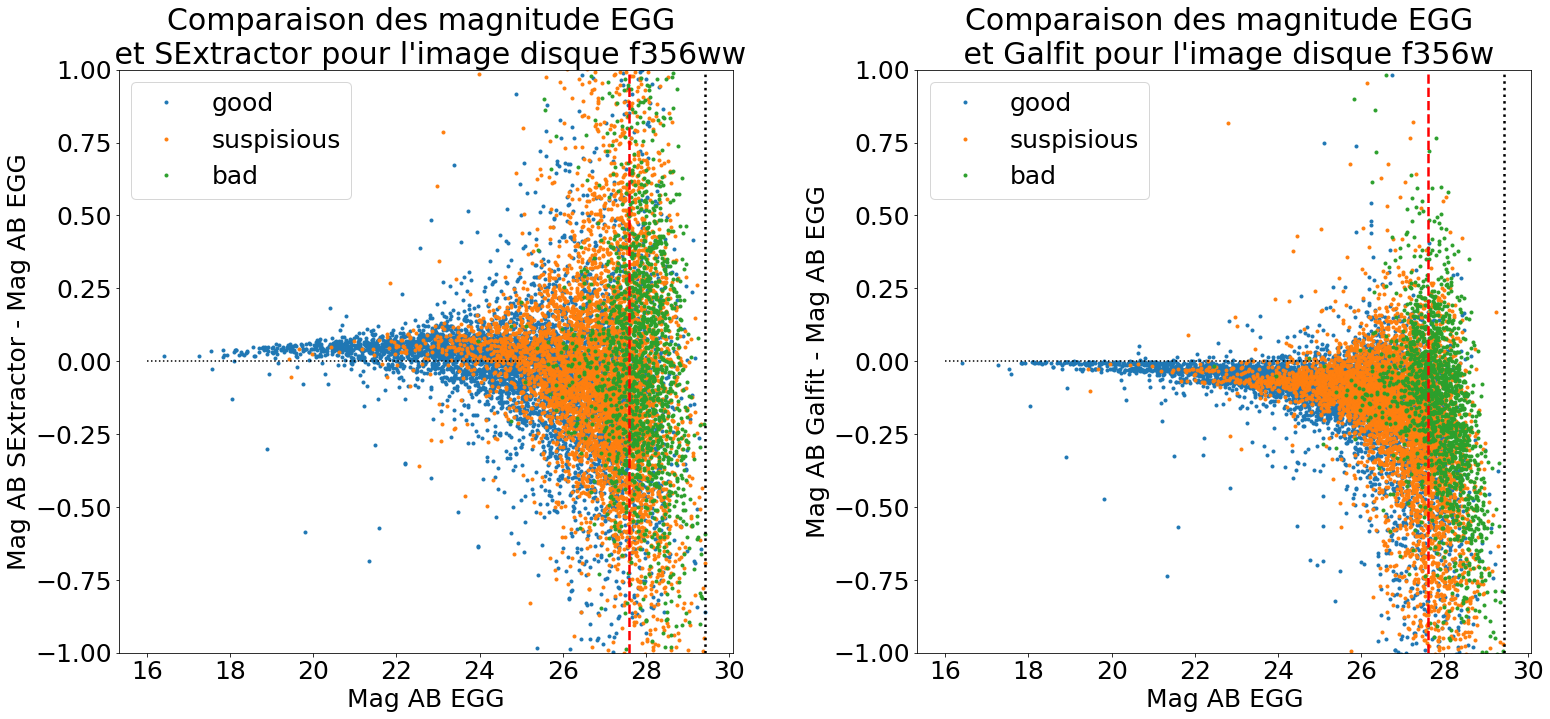

In [23]:
plt.figure(figsize=(18,9))
plt.subplots_adjust(left=0.01, bottom=0.1, right=1.1, top=1, wspace=0.3, hspace=0.3)

plt.subplot(121)
plt.plot(mag[mag_detect][cores_out_in[ok]][ngood],data_disk['MAG_BEST'][ok][ngood]-mag[mag_detect][cores_out_in[ok]][ngood],".",label="good")
plt.plot(mag[mag_detect][cores_out_in[ok]][nsuspisious],data_disk['MAG_BEST'][ok][nsuspisious]-mag[mag_detect][cores_out_in[ok]][nsuspisious],".",label="suspisious")
plt.plot(mag[mag_detect][cores_out_in[ok]][nbad],data_disk['MAG_BEST'][ok][nbad]-mag[mag_detect][cores_out_in[ok]][nbad],".",label="bad")
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.plot(np.arange(16,27,3),np.zeros(np.arange(16,27,3).shape[0]),"k:")
plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB SExtractor - Mag AB EGG', fontsize=25)
plt.title("Comparaison des magnitude EGG \n et SExtractor pour l'image disque f356ww",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(-1,1)
plt.legend(fontsize=25)

plt.subplot(122)
plt.plot(mag[mag_detect][cores_out_in[ok]][ngood],data_disk['MAG_GALFIT'][ok][ngood]-mag[mag_detect][cores_out_in[ok]][ngood],".",label="good")
plt.plot(mag[mag_detect][cores_out_in[ok]][nsuspisious],data_disk['MAG_GALFIT'][ok][nsuspisious]-mag[mag_detect][cores_out_in[ok]][nsuspisious],".",label="suspisious")
plt.plot(mag[mag_detect][cores_out_in[ok]][nbad],data_disk['MAG_GALFIT'][ok][nbad]-mag[mag_detect][cores_out_in[ok]][nbad],".",label="bad")
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.plot(np.arange(16,27,3),np.zeros(np.arange(16,27,3).shape[0]),"k:")
plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB EGG', fontsize=25)
plt.title("Comparaison des magnitude EGG \n et Galfit pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(-1,1)
plt.legend(fontsize=25)
plt.show()

In [24]:
%matplotlib inline

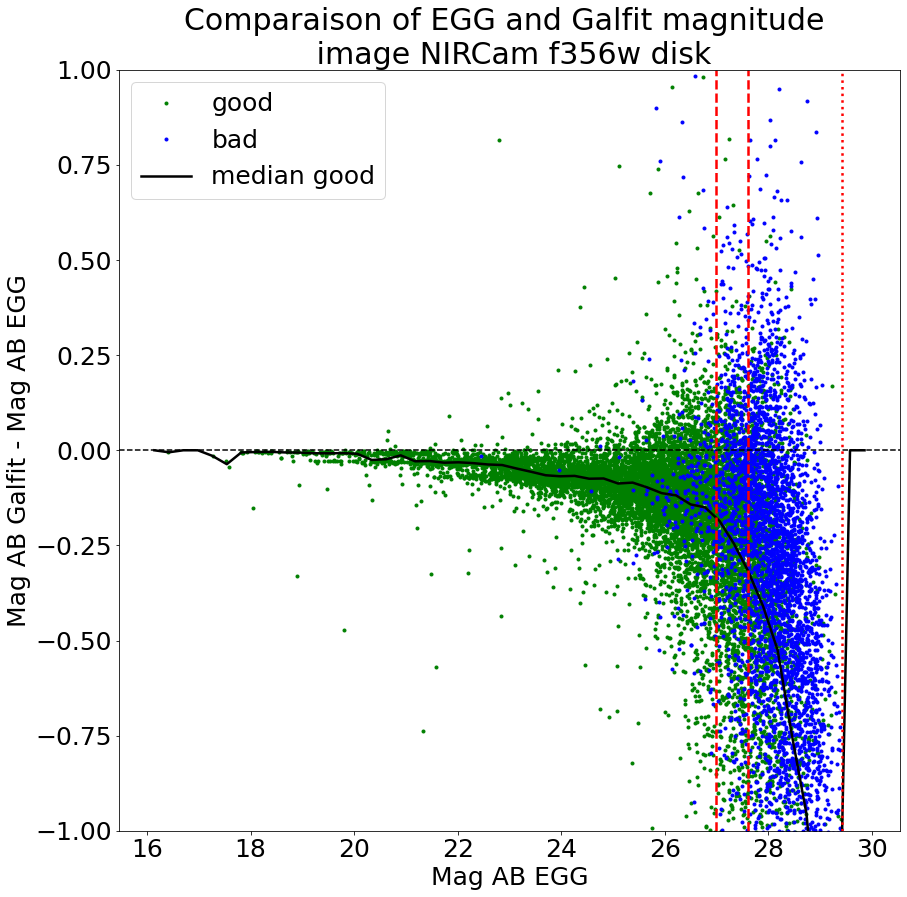

In [26]:
re = []
low_err, high_err = [],[]
mag_re=[]

bx=50

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    #dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in[ok]][f[i]]>minx) & (mag[mag_detect][cores_out_in[ok]][f[i]]<maxx))
        
        if len(data_disk['MAG_GALFIT'][ok][f[i]][m_index]-mag[mag_detect][cores_out_in[ok]][f[i]][m_index]) >=1 :
            r.append(np.median(((data_disk['MAG_GALFIT'][ok][f[i]][m_index]-mag[mag_detect][cores_out_in[ok]][f[i]][m_index]))))
        else :
            r.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)

    
    mag_re.append(ml)

plt.figure(figsize=(14,14))

plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],data_disk['MAG_GALFIT'][ok][ngs]-mag[mag_detect][cores_out_in[ok]][ngs],"g.",label="good")
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],data_disk['MAG_GALFIT'][ok][nbn]-mag[mag_detect][cores_out_in[ok]][nbn],"b.",label="bad")
plt.plot(mag_re[0],re[0],"k-",label="median good", linewidth=2.5)

plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB EGG', fontsize=25)
plt.title("Comparaison of EGG and Galfit magnitude \n image NIRCam f356w disk",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(-1,1)
plt.legend(fontsize=25)
plt.show()

### Re 

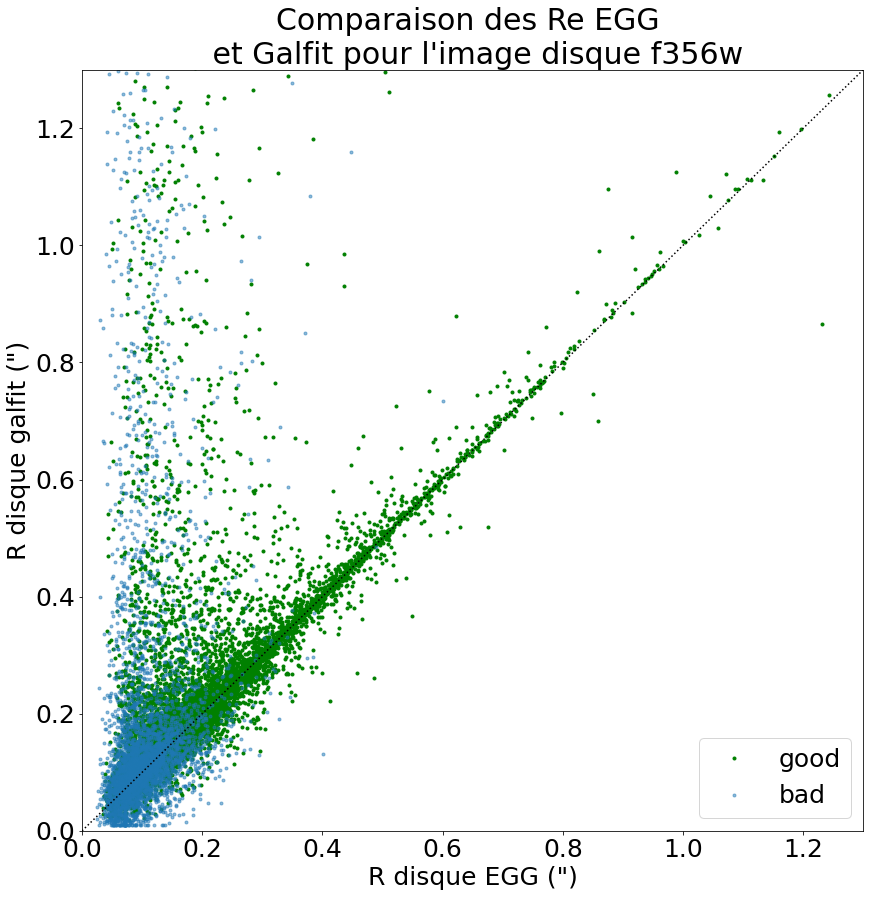

In [28]:
plt.figure(figsize=(14,14))
plt.plot(r_disk[mag_detect][cores_out_in[ok]][ngs],data_disk['RE_GALFIT'][ok][ngs]*pixel_scale,".",color=("g"),label="good")
plt.plot(r_disk[mag_detect][cores_out_in[ok]][nbn],data_disk['RE_GALFIT'][ok][nbn]*pixel_scale,".",alpha=0.5,color=("tab:blue"),label="bad")

plt.plot(np.arange(0,4,3),np.arange(0,4,3),"k:")
plt.xlabel('R disque EGG (")',fontsize=25)
plt.ylabel('R disque galfit (")', fontsize=25)
plt.title("Comparaison des Re EGG \n et Galfit pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(0,1.3)
plt.xlim(0,1.3)
plt.legend(fontsize=25)
plt.show()

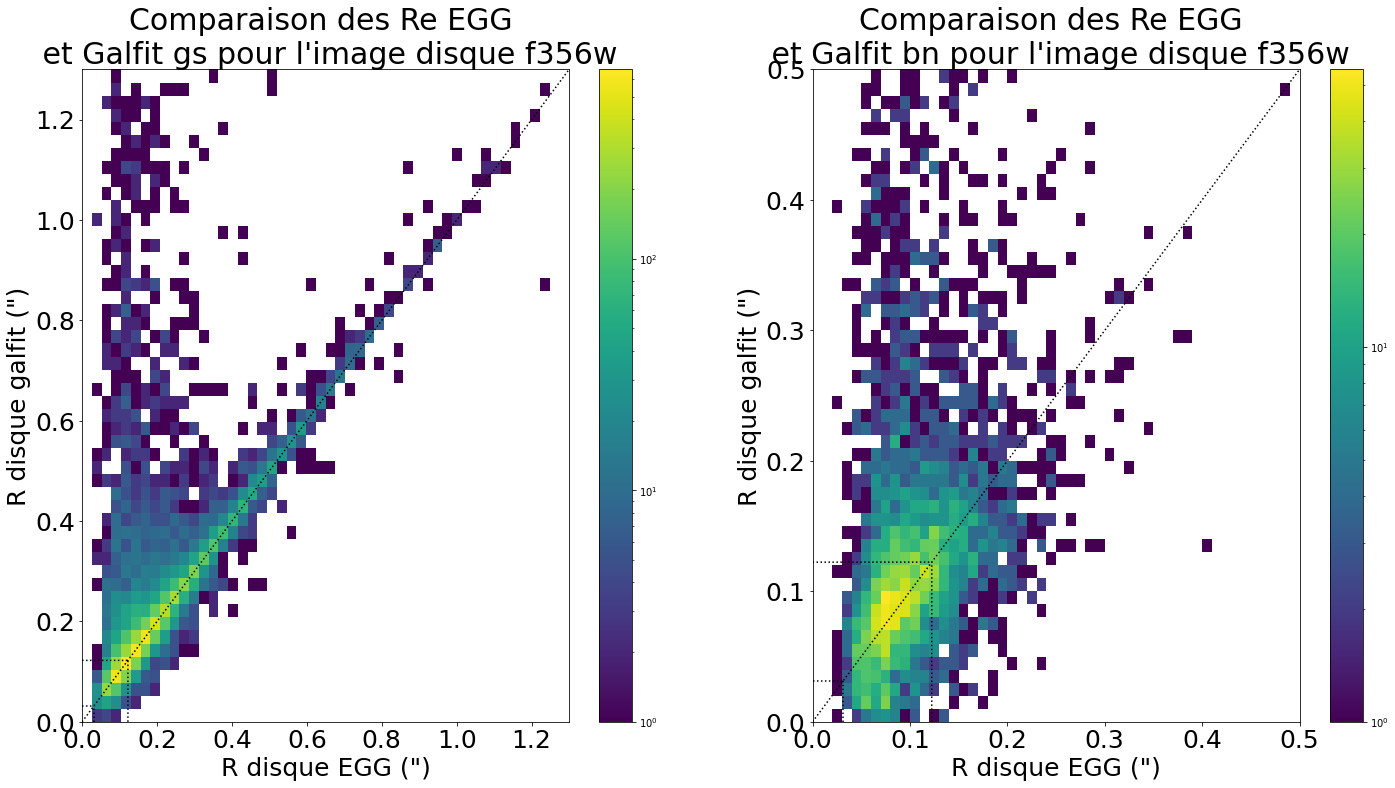

In [29]:
%matplotlib inline
plt.figure(figsize=(24,12))

plt.subplot(121)
plt.hist2d(r_disk[mag_detect][cores_out_in[ok]][ngs],data_disk['RE_GALFIT'][ok][ngs]*pixel_scale,range=[[0, 1.3], [0, 1.3]],bins=50,norm=LogNorm())
plt.plot(np.arange(0,4,3),np.arange(0,4,3),"k:")
plt.xlabel('R disque EGG (")',fontsize=25)
plt.ylabel('R disque galfit (")', fontsize=25)
plt.title("Comparaison des Re EGG \n et Galfit gs pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.colorbar()

fw=3.56/6e6/np.pi*180*3600
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

fw=pixel_scale
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

plt.subplot(122)
plt.hist2d(r_disk[mag_detect][cores_out_in[ok]][nbn],data_disk['RE_GALFIT'][ok][nbn]*pixel_scale,range=[[0, 0.5], [0, 0.5]],bins=50,norm=LogNorm())
plt.plot(np.arange(0,4,3),np.arange(0,4,3),"k:")
plt.xlabel('R disque EGG (")',fontsize=25)
plt.ylabel('R disque galfit (")', fontsize=25)
plt.title("Comparaison des Re EGG \n et Galfit bn pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.colorbar()

fw=3.56/6e6/np.pi*180*3600
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

fw=pixel_scale
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

plt.show()

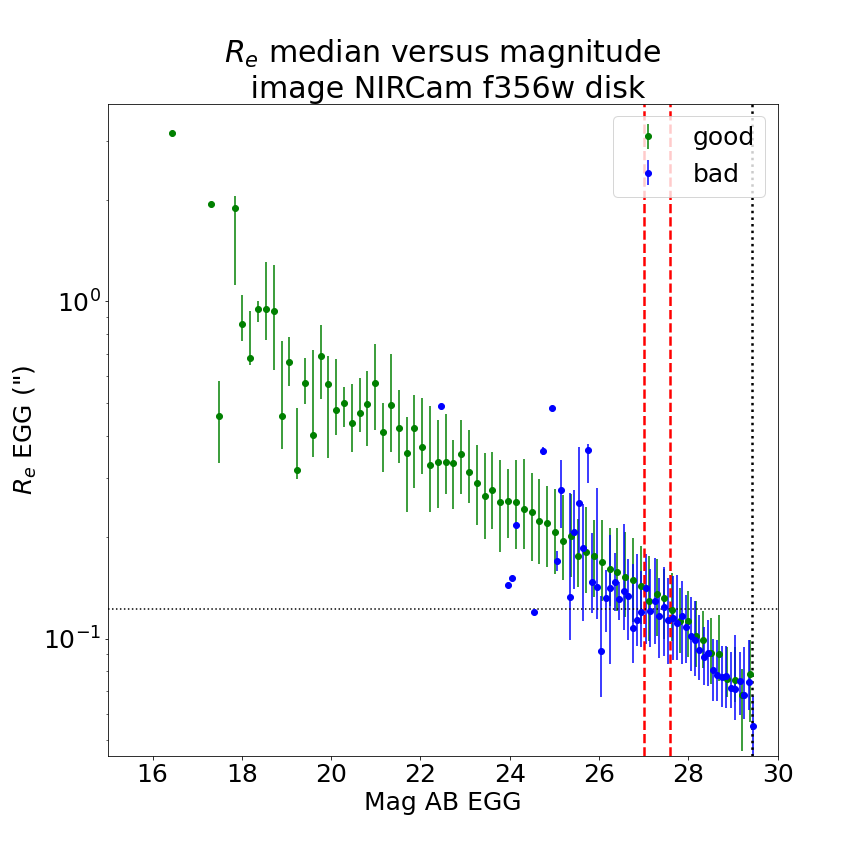

In [30]:
re = []
low_err, high_err = [],[]
mag_re=[]

bx=80

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in[ok]][f[i]]>minx) & (mag[mag_detect][cores_out_in[ok]][f[i]]<maxx))
        
        if len(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]) >=1 :
            r.append(np.median(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]))
            dl.append(abs(np.median(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])-np.quantile(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index],0.25)))
            dh.append(abs(np.median(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])-np.quantile(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index],0.75)))
        else :
            r.append(0)
            dl.append(0)
            dh.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)
    
    low_err.append(dl)
    high_err.append(dh)
    
    mag_re.append(ml)

errg = [low_err[0],high_err[0]]
errs = [low_err[1],high_err[1]]

%matplotlib widget
plt.figure(figsize=(12,12))
plt.errorbar(mag_re[0],re[0],yerr=errg,fmt="go",label="good")
plt.errorbar(mag_re[1],re[1],yerr=errs,fmt="bo",label="bad")
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=3.56/6e6/np.pi*180*3600,color='k',linestyle=':')
#plt.axhline(y=pixel_scale,linestyle='--')
plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'$R_e$ EGG (")', fontsize=25)
plt.title(r'$R_e$ median versus magnitude' + '\n image NIRCam f356w disk', fontsize=30)
plt.xlim(15,30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper right',fontsize=25)
#plt.ylim(5e-2,7e-1)
#plt.ylim(0,0.5)
plt.semilogy()
plt.show()

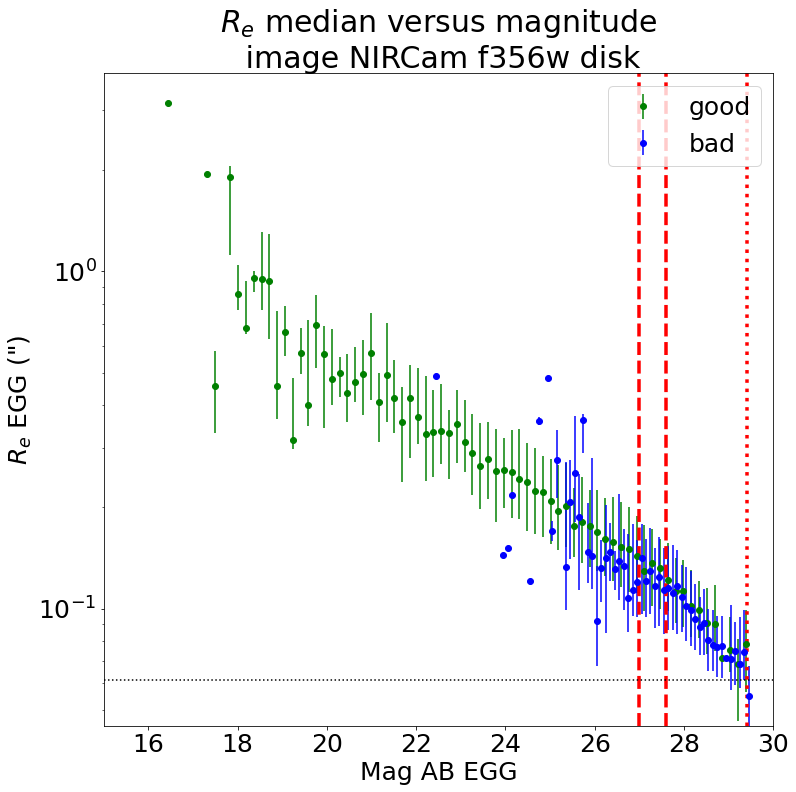

In [24]:
%matplotlib inline
re = []
low_err, high_err = [],[]
mag_re=[]

bx=80

f=[gs,bn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in][f[i]].min())+( int(mag[mag_detect][cores_out_in][f[i]].max()+1)-int(mag[mag_detect][cores_out_in][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in][f[i]].min())+( int(mag[mag_detect][cores_out_in][f[i]].max()+1)-int(mag[mag_detect][cores_out_in][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in][f[i]]>minx) & (mag[mag_detect][cores_out_in][f[i]]<maxx))
        
        if len(r_disk[mag_detect][cores_out_in][f[i]][m_index]) >=1 :
            r.append(np.median(r_disk[mag_detect][cores_out_in][f[i]][m_index]))
            dl.append(abs(np.median(r_disk[mag_detect][cores_out_in][f[i]][m_index])-np.quantile(r_disk[mag_detect][cores_out_in][f[i]][m_index],0.25)))
            dh.append(abs(np.median(r_disk[mag_detect][cores_out_in][f[i]][m_index])-np.quantile(r_disk[mag_detect][cores_out_in][f[i]][m_index],0.75)))
        else :
            r.append(0)
            dl.append(0)
            dh.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)
    
    low_err.append(dl)
    high_err.append(dh)
    
    mag_re.append(ml)
    
re_nd=[]
dl_nd,dh_nd=[],[]
ml_nd=[]
    
for j in range(bx) :
        
    minx= int(mag[mag_detect][non_detct].min())+( int(mag[mag_detect][non_detct].max()+1)-int(mag[mag_detect][non_detct].min())  )/bx*j
    maxx= int(mag[mag_detect][non_detct].min())+( int(mag[mag_detect][non_detct].max()+1)-int(mag[mag_detect][non_detct].min())  )/bx*(j+1)
    
    m_index,=np.where((mag[mag_detect][non_detct]>minx) & (mag[mag_detect][non_detct]<maxx))
        
    if len(r_disk[mag_detect][non_detct][m_index]) >=1 :
        re_nd.append(np.median(r_disk[mag_detect][non_detct][m_index]))
        dl_nd.append(abs(np.median(r_disk[mag_detect][non_detct][m_index])-np.quantile(r_disk[mag_detect][non_detct][m_index],0.25)))
        dh_nd.append(abs(np.median(r_disk[mag_detect][non_detct][m_index])-np.quantile(r_disk[mag_detect][non_detct][m_index],0.75)))
    else :
        re_nd.append(0)
        dl_nd.append(0)
        dh_nd.append(0)
    ml_nd.append((minx+maxx)/2)
    
errg = [low_err[0],high_err[0]]
errs = [low_err[1],high_err[1]]
errn = [dl_nd,dh_nd]

fwhm = 3.56/6e6/np.pi*180*3600

%matplotlib inline
plt.figure(figsize=(12,12))
plt.errorbar(mag_re[0],re[0],yerr=errg,fmt="go",label="good")
plt.errorbar(mag_re[1],re[1],yerr=errs,fmt="bo",label="bad")
#plt.errorbar(ml_nd,re_nd,yerr=errn,fmt="ro",label="non detect")
plt.axvline(x=29.42,color='r',linestyle=':', linewidth=3.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=3.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=3.5)
plt.axhline(y=fwhm/2,color='k',linestyle=':')
#plt.axhline(y=pixel_scale,linestyle='--')
plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'$R_e$ EGG (")', fontsize=25)
plt.title(r'$R_e$ median versus magnitude' + '\n image NIRCam f356w disk', fontsize=30)
plt.xlim(15,30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper right',fontsize=25)
#plt.ylim(5e-2,7e-1)
#plt.ylim(0,0.5)
plt.semilogy()
plt.show()

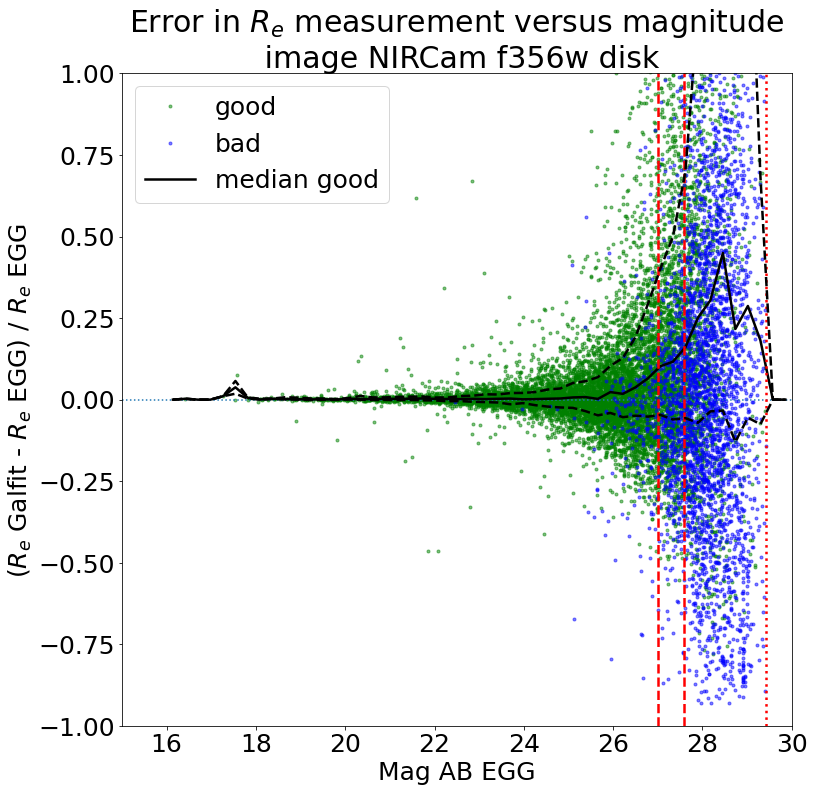

In [19]:
%matplotlib inline

re = []
low_err, high_err = [],[]
mag_re=[]

bx=50

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in][f[i]]>minx) & (mag[mag_detect][cores_out_in][f[i]]<maxx))
        
        if len(r_disk[mag_detect][cores_out_in][f[i]][m_index]) >=1 :
            r.append(np.median((data_disk['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])))
            dl.append(abs(np.median((data_disk['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]))-
                          np.quantile((data_disk['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]),0.25)))
            dh.append(abs(np.median((data_disk['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]))-
                          np.quantile((data_disk['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_disk[mag_detect][cores_out_in[ok]][f[i]][m_index]),0.75)))
        else :
            r.append(0)
            dl.append(0)
            dh.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)
    
    low_err.append(dl)
    high_err.append(dh)
    
    mag_re.append(ml)


    
errg = [low_err[0],high_err[0]]
errs = [low_err[1],high_err[1]]

p_re = (data_disk['RE_GALFIT'][ok][ngs]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][ngs])/(r_disk[mag_detect][cores_out_in[ok]][ngs])
p_re_bn = (data_disk['RE_GALFIT'][ok][nbn]*pixel_scale-r_disk[mag_detect][cores_out_in[ok]][nbn])/(r_disk[mag_detect][cores_out_in[ok]][nbn])
plt.figure(figsize=(12,12))

plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],p_re,'g.',alpha=0.5,label='good')
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],p_re_bn,'b.',alpha=0.5,label='bad')
plt.plot(np.arange(15,35,3),np.zeros(np.arange(15,35,3).shape[0]),":")
plt.plot(mag_re[0],re[0],"k-",label="median good", linewidth=2.5)

plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)

plt.plot(mag_re[0],np.array(re[0])-np.array(low_err[0]),'k--', linewidth=2.5)
plt.plot(mag_re[0],np.array(re[0])+np.array(high_err[0]),'k--',linewidth=2.5)

plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'($R_e$ Galfit - $R_e$ EGG) / $R_e$ EGG', fontsize=25)
plt.title( r'Error in $R_e$ measurement versus magnitude' + '\n image NIRCam f356w disk', fontsize=30)
plt.xlim(15,30)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

### Sersic 

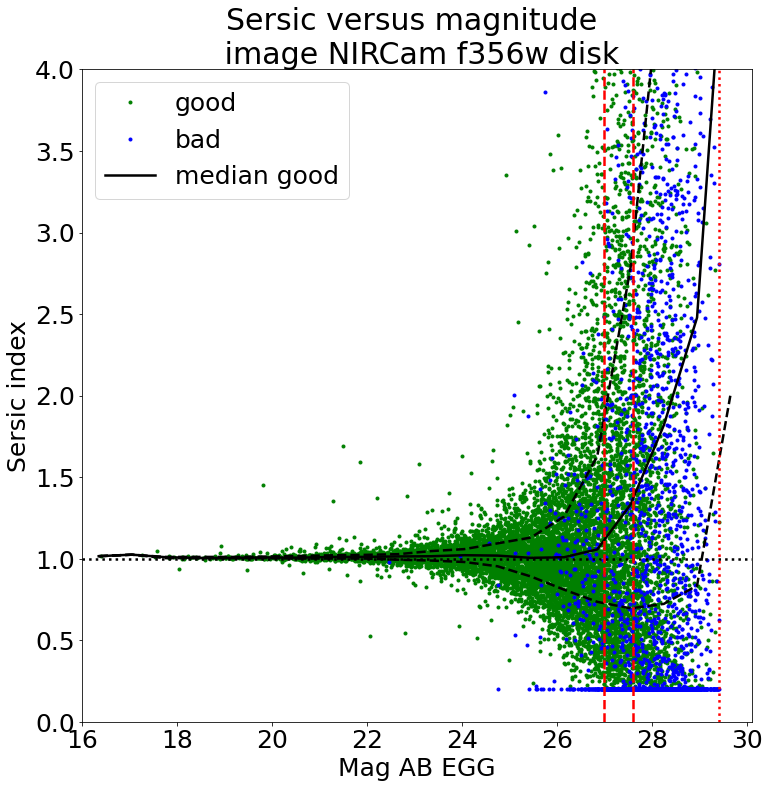

In [20]:
%matplotlib inline

sersic = []
mag_s=[]
low_err, high_err = [],[]

bx=20

for j in range(bx) :
    
    minx= int(mag[mag_detect][cores_out_in[ok]][ngs].min())+( int(mag[mag_detect][cores_out_in[ok]][ngs].max()+1)-int(mag[mag_detect][cores_out_in[ok]][ngs].min())  )/bx*j
    maxx= int(mag[mag_detect][cores_out_in[ok]][ngs].min())+( int(mag[mag_detect][cores_out_in[ok]][ngs].max()+1)-int(mag[mag_detect][cores_out_in[ok]][ngs].min())  )/bx*(j+1)
    
    m_index,=np.where((mag[mag_detect][cores_out_in[ok]][ngs]>minx) & (mag[mag_detect][cores_out_in[ok]][ngs]<maxx))
    
    if data_disk['SERSIC_GALFIT'][ok][ngs][m_index].shape[0]>=1 : 
        sersic.append(np.median(data_disk['SERSIC_GALFIT'][ok][ngs][m_index]))
        low_err.append(abs(np.median(data_disk['SERSIC_GALFIT'][ok][ngs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][ok][ngs][m_index],0.25)))
        high_err.append(abs(np.median(data_disk['SERSIC_GALFIT'][ok][ngs][m_index])-np.quantile(data_disk['SERSIC_GALFIT'][ok][ngs][m_index],0.75)))
        
    else :
        sersic.append(0)
        low_err.append(0)
        high_err.append(0)
        
    mag_s.append((minx+maxx)/2)

plt.figure(figsize=(12,12))
plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],data_disk['SERSIC_GALFIT'][ok][ngs],'g.',label='good')
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],data_disk['SERSIC_GALFIT'][ok][nbn],'b.',label='bad')

plt.plot(mag_s,sersic,'k',label="median good", linewidth=2.5)
plt.plot(mag_s,np.array(sersic)-np.array(low_err),'k--', linewidth=2.5)
plt.plot(mag_s,np.array(sersic)+np.array(high_err),'k--',linewidth=2.5)

plt.axhline(y=1,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=27.6,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=27.0,color='r',linestyle='--', linewidth=2.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Sersic index', fontsize=25)
plt.title('Sersic versus magnitude \n image NIRCam f356w disk', fontsize=30)
plt.xlim(16,30.1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left',fontsize=25)
plt.ylim(0.,4)
plt.show()

### SFR

In [24]:
bx=60 #bin x
by=60 #bin y
zb=[0,0.5,1,1.5,2.5,3.5,15]

imgz=[]
t = []
g = []

for k in trange(len(zb)-1):

    img=[]
    
    tot=np.zeros((bx,by))
    ntg=np.zeros((bx,by))

    for i in range(by) : 
        l=[]
        
        
        
        for j in range(bx) :
            zl = np.where((z[mag_detect]>zb[k])&(z[mag_detect]<zb[k+1]))[0]
            minx= int(m[mag_detect][zl].min())+( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/bx*j
            maxx= int(m[mag_detect][zl].min())+( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/bx*(j+1)
            miny= int(np.log10(sfr[mag_detect][zl]).min()-1)+( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1 ) )/by*i
            maxy= int(np.log10(sfr[mag_detect][zl]).min()-1)+( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1) )/by*(i+1)
            
            
            nt = np.where( (m[mag_detect][zl]>minx) & (m[mag_detect][zl]<maxx) & (np.log10(sfr[mag_detect][zl]) > miny) & (np.log10(sfr[mag_detect][zl]) < maxy) )[0].shape[0]
            
            tot[i][j]=nt

            if nt ==0 :
                l.append([1.,1.,1.])
                
            else:
                
                zl = np.where((z[mag_detect][cores_out_in][gs]>zb[k])&(z[mag_detect][cores_out_in][gs]<zb[k+1]))[0]
                ngs = np.where( (m[mag_detect][cores_out_in][gs][zl]>minx) & (m[mag_detect][cores_out_in][gs][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][gs][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][gs][zl]) < maxy) )[0].shape[0]/nt
                
                ntg[i][j]=np.where( (m[mag_detect][cores_out_in][gs][zl]>minx) & (m[mag_detect][cores_out_in][gs][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][gs][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][gs][zl]) < maxy) )[0].shape[0]
                
                zl = np.where((z[mag_detect][cores_out_in][bn]>zb[k])&(z[mag_detect][cores_out_in][bn]<zb[k+1]))[0]
                nbn = np.where( (m[mag_detect][cores_out_in][bn][zl]>minx) & (m[mag_detect][cores_out_in][bn][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][bn][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][bn][zl]) < maxy) )[0].shape[0]/nt
                
                zl = np.where((z[mag_detect][non_detct]>zb[k])&(z[mag_detect][non_detct]<zb[k+1]))[0]
                nnf = np.where( (m[mag_detect][non_detct][zl]>minx) & (m[mag_detect][non_detct][zl]<maxx) & 
                                (np.log10(sfr[mag_detect][non_detct][zl]) > miny) & (np.log10(sfr[mag_detect][non_detct][zl]) < maxy) )[0].shape[0]/nt
                l.append([nnf,ngs,nbn])
                
                

        img.append(l)
    t.append(tot)
    g.append(ntg)
    imgz.append(img)

  0%|          | 0/6 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


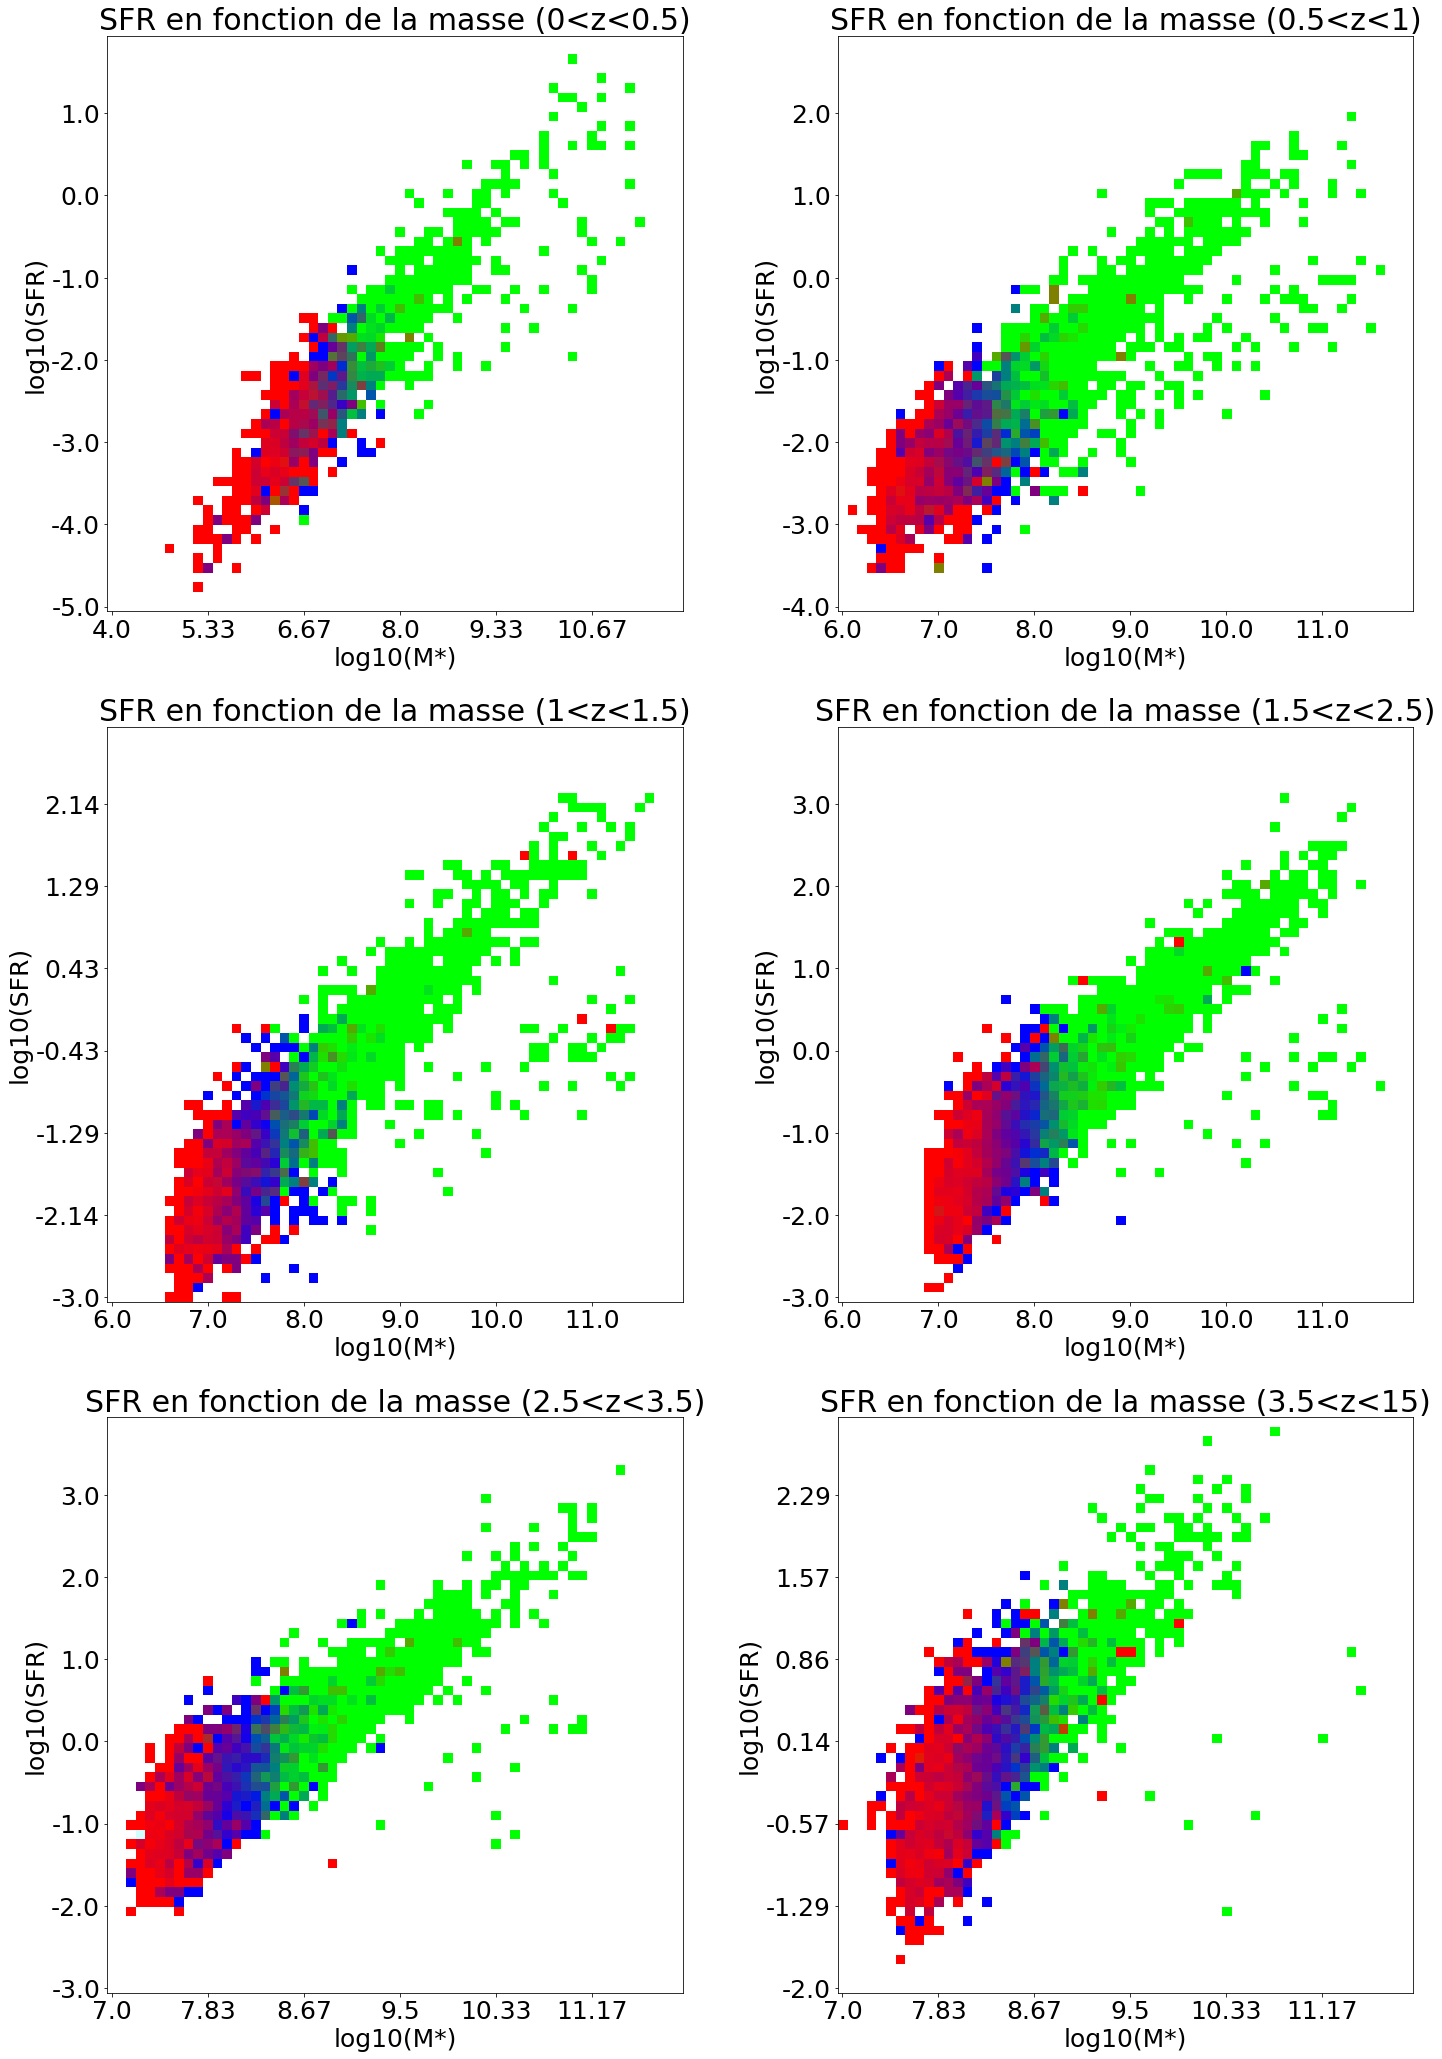

In [37]:
%matplotlib inline


plt.figure(figsize=(24,36))

for i in range(len(zb)-1):
    plt.subplot(3,2,i+1)
    plt.imshow(imgz[i],origin='lower')
    
    plt.title("SFR en fonction de la masse ({}<z<{})".format(zb[i],zb[i+1]),fontsize=30)
    
    zl = np.where((z[mag_detect]>zb[i])&(z[mag_detect]<zb[i+1]))[0]
    ntx = 6
    nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
    lx=np.around(np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/ntx),decimals=2)

    nty = 7
    ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
    ly=np.around(np.arange(int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1),( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1)  )/nty),decimals=2)

    plt.xlabel('log10(M*)',fontsize=25)
    plt.ylabel('log10(SFR)', fontsize=25)
    plt.xticks(nx,lx,fontsize=25)
    plt.yticks(ny,ly,fontsize=25)
#plt.colorbar()
plt.show()

/tmp/ipykernel_39997/1031673776.py:13: RuntimeWarning: invalid value encountered in true_divide
  sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
/tmp/ipykernel_39997/1031673776.py:17: RuntimeWarning: invalid value encountered in true_divide
  mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)


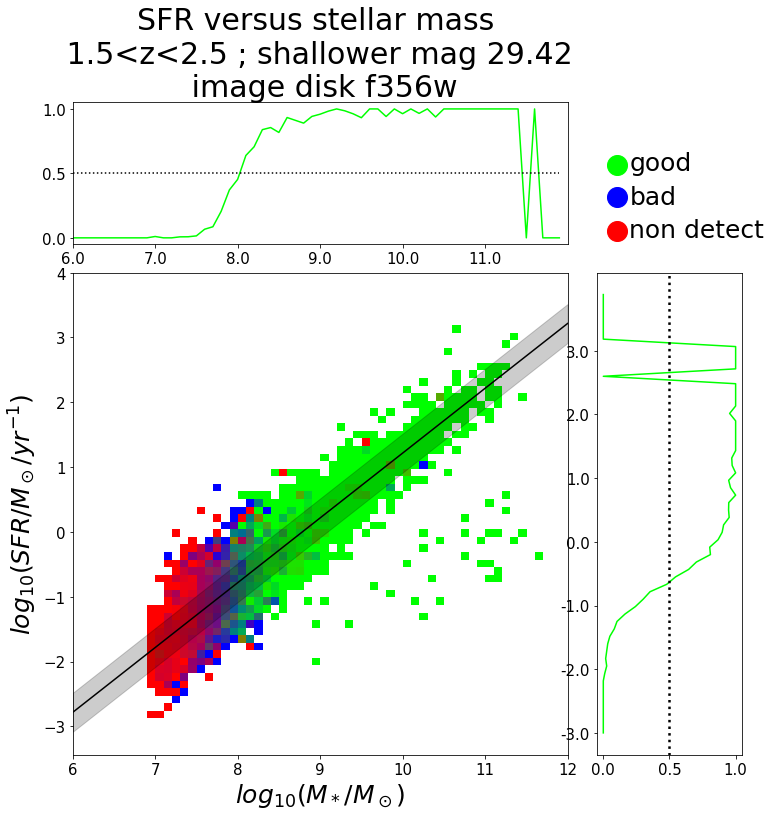

In [31]:
i=3

zl = np.where((z[mag_detect]>zb[i])&(z[mag_detect]<zb[i+1]))[0]
ntx = 6
nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
lx=np.around(np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/ntx),decimals=2)

nty = 7
ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
ly=np.around(np.arange(int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1),( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1)  )/nty),decimals=2)


sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
sfrg[np.isnan(sfrg)]=0
x=np.arange(sfrg.shape[0])

mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)
mg[np.isnan(mg)]=0
y=np.arange(mg.shape[0])

xMS = np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1)+0.1,0.1)
logzMS = np.log10(1+(zb[i]+zb[i+1])/2)
yMS=xMS-9.5+1.5*logzMS-0.3*(max(0,xMS.any()-9.36-2.5*logzMS))**2



fig=plt.figure(figsize=(12,12))
axes=fig.subplot_mosaic(
    """
    aaal
    bbbc
    bbbc
    bbbc
    """)

axes['a'].set_title("SFR versus stellar mass \n {}<z<{} ; shallower mag 29.42 \n image disk f356w".format(zb[i],zb[i+1]),fontsize=30)

axes['a'].plot(x,sfrg,color=(0,1,0))
axes['a'].plot(x,np.ones(x.shape[0])*0.5,'k:')
axes['a'].set_xticks(nx,lx,fontsize=15)
axes['a'].set_xlim(0,sfrg.shape[0])
axes['a'].tick_params(axis='y', labelsize= 15)

axes['c'].plot(mg,y,color=(0,1,0))
axes['c'].set_yticks(ny,ly,fontsize=15)
axes['c'].axvline(x=0.5,color='k',linestyle=':', linewidth=2.5)
axes['c'].tick_params(axis='x', labelsize= 15)

axes['b'].imshow(imgz[i],origin='lower',
                extent=[int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1)],aspect='auto')
axes['b'].set_xlabel(r'$log_{10}(M_*/M_\odot)$',fontsize=25)
axes['b'].set_ylabel(r'$log_{10}(SFR/M_\odot/yr^{-1})$', fontsize=25)
axes['b'].tick_params(axis='x', labelsize= 15)
axes['b'].tick_params(axis='y', labelsize= 15)
axes['b'].plot(xMS,yMS,'k-')
axes['b'].fill_between(xMS,yMS-0.3,yMS+0.3,color='k',alpha=0.2)

axes['l'].plot(0,2.15,'o',color=(0,1,0),ms=20,label='good')
axes['l'].plot(0,1.2,'bo',ms=20,label='bad')
axes['l'].plot(0,0.2,'ro',ms=20,label='non detect')
axes['l'].set_xlim(-0.008,0.05)
axes['l'].set_ylim(-0.2,4)
axes['l'].text(0.005,2,"good",fontsize=25)
axes['l'].text(0.005,1,"bad",fontsize=25)
axes['l'].text(0.005,0,"non detect",fontsize=25)
axes['l'].axis('off')

plt.show()

In [30]:
%matplotlib inline

In [29]:
int(np.log10(sfr[mag_detect][zl]).min()-1)+( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1 ) )/by*20.3

-0.6316666666666664

In [28]:
int(m[mag_detect][zl].min())+( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/bx*20.25

8.025

/tmp/ipykernel_59128/177243190.py:13: RuntimeWarning: invalid value encountered in true_divide
  sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
/tmp/ipykernel_59128/177243190.py:17: RuntimeWarning: invalid value encountered in true_divide
  mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


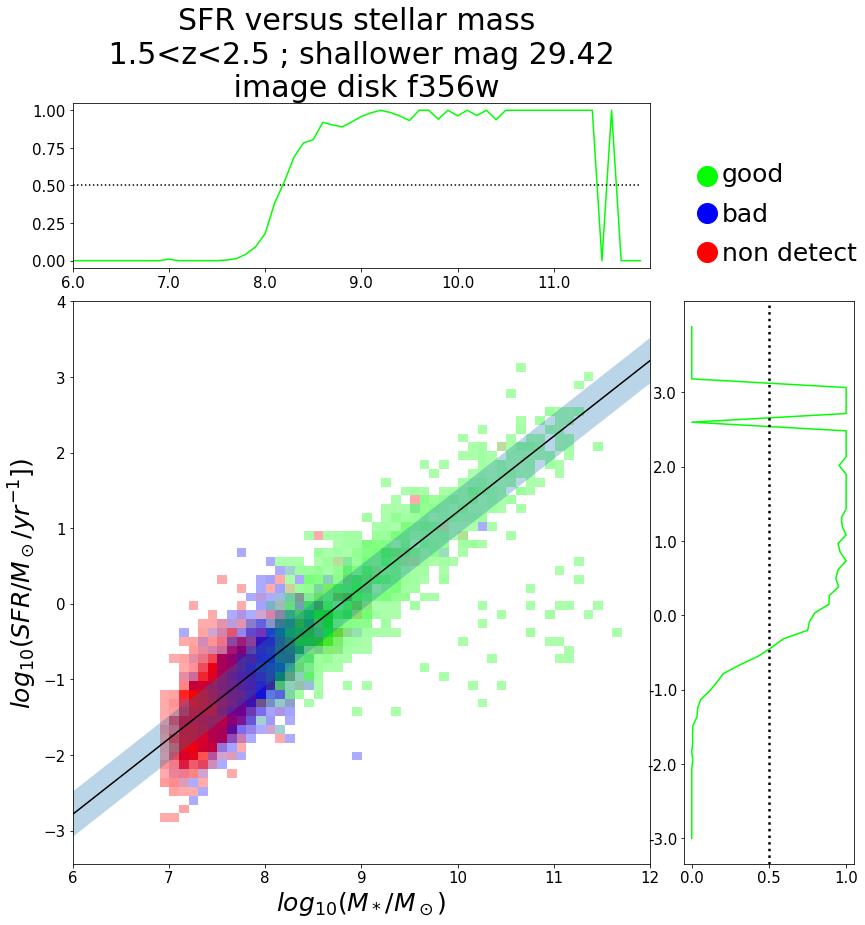

In [42]:
i=3

zl = np.where((z[mag_detect]>zb[i])&(z[mag_detect]<zb[i+1]))[0]
ntx = 6
nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
lx=np.around(np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/ntx),decimals=2)

nty = 7
ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
ly=np.around(np.arange(int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1),( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1)  )/nty),decimals=2)


sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
sfrg[np.isnan(sfrg)]=0
x=np.arange(sfrg.shape[0])

mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)
mg[np.isnan(mg)]=0
y=np.arange(mg.shape[0])

xMS = np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1)+0.1,0.1)
logzMS = np.log10(1+(zb[i]+zb[i+1])/2)
yMS=xMS-9.5+1.5*logzMS-0.3*(max(0,xMS.any()-9.36-2.5*logzMS))**2

imgz_alpha=deepcopy(imgz[i])
al = 3*t[i]/t[i].max()+0.3
for k in range(len(imgz_alpha)) :
    for j in range(len(imgz_alpha[0])):
        imgz_alpha[k][j].append(al[k][j])

fig=plt.figure(figsize=(14,14))
axes=fig.subplot_mosaic(
    """
    aaal
    bbbc
    bbbc
    bbbc
    """)

axes['a'].set_title("SFR versus stellar mass \n {}<z<{} ; shallower mag 29.42 \n image disk f356w".format(zb[i],zb[i+1]),fontsize=30)

axes['a'].plot(x,sfrg,color=(0,1,0))
axes['a'].plot(x,np.ones(x.shape[0])*0.5,'k:')
axes['a'].set_xticks(nx,lx,fontsize=15)
axes['a'].set_xlim(0,sfrg.shape[0])
axes['a'].tick_params(axis='y', labelsize= 15)

axes['c'].plot(mg,y,color=(0,1,0))
axes['c'].set_yticks(ny,ly,fontsize=15)
axes['c'].axvline(x=0.5,color='k',linestyle=':', linewidth=2.5)
axes['c'].tick_params(axis='x', labelsize= 15)

axes['b'].imshow(imgz_alpha,origin='lower',
                extent=[int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1)],aspect='auto')
axes['b'].set_xlabel(r'$log_{10}(M_*/M_\odot)$',fontsize=25)
axes['b'].set_ylabel(r'$log_{10}(SFR/M_\odot/yr^{-1}])$', fontsize=25)
axes['b'].tick_params(axis='x', labelsize= 15)
axes['b'].tick_params(axis='y', labelsize= 15)
axes['b'].plot(xMS,yMS,'k-')
axes['b'].fill_between(xMS,yMS-0.3,yMS+0.3,alpha=0.3)

axes['l'].plot(0,2.15,'o',color=(0,1,0),ms=20,label='good')
axes['l'].plot(0,1.2,'bo',ms=20,label='bad')
axes['l'].plot(0,0.2,'ro',ms=20,label='non detect')
axes['l'].set_xlim(-0.008,0.05)
axes['l'].set_ylim(-0.2,4)
axes['l'].text(0.005,2,"good",fontsize=25)
axes['l'].text(0.005,1,"bad",fontsize=25)
axes['l'].text(0.005,0,"non detect",fontsize=25)
axes['l'].axis('off')

plt.show()

In [43]:
%matplotlib inline

# Image bulge

## cat 

In [5]:
bulge = fits.open("combcat356_bulge_final2.fits")
data_bulge=bulge[1].data
hdu_bulge=bulge[1].header

In [6]:
print("Nombres de galaxies fité par GALFIT :",data_bulge['FIT_DONE'].shape[0])

Nombres de galaxies fité par GALFIT : 25191


In [8]:
good_b, susp_b, bad_b, nan_b = flag_results(data_bulge)

gs_b=np.concatenate((good_b,susp_b))
bn_b=np.concatenate((bad_b,nan_b))

In [8]:
good_b, susp_b, bad_b, nan_b = flag_results_m80(data_bulge,24.4)

gs_b=np.concatenate((good_b,susp_b))
bn_b=np.concatenate((bad_b,nan_b))

In [9]:
good_b.shape[0]+susp_b.shape[0]+bad_b.shape[0]+nan_b.shape[0]

25191

In [8]:
print("nombre de galaxies utilisable :",good_b.shape[0]+susp_b.shape[0], ", c'est-à-dire", good_b.shape[0], "good et",susp_b.shape[0],"suspect")

nombre de galaxies utilisable : 1081 , c'est-à-dire 928 good et 153 suspect


In [9]:
print("good : ",good_b.shape[0]/data_bulge['FIT_DONE'].shape[0], "\nsuspisious : ",susp_b.shape[0]/data_bulge['FIT_DONE'].shape[0],"\nbad :",bad_b.shape[0]/data_bulge['FIT_DONE'].shape[0],"\nfail : ",nan_b.shape[0]/data_bulge['FIT_DONE'].shape[0])

good :  0.03683855345162955 
suspisious :  0.006073597713469096 
bad : 0.14298757492755348 
fail :  0.8141002739073478


In [10]:
print("good : ",gs_b.shape[0]/data_bulge['FIT_DONE'].shape[0], "\nbad : ",bn_b.shape[0]/data_bulge['FIT_DONE'].shape[0])

good :  0.042912151165098646 
bad :  0.9570878488349014


## Img 

In [27]:
img=fits.open("/local/home/fs269899/stage/egg_jwst/PRIMER/NIRCam/f356w/egg-20220325-jwst-f356w-sci_2_bulge.fits")
img_bulge=img[0].data

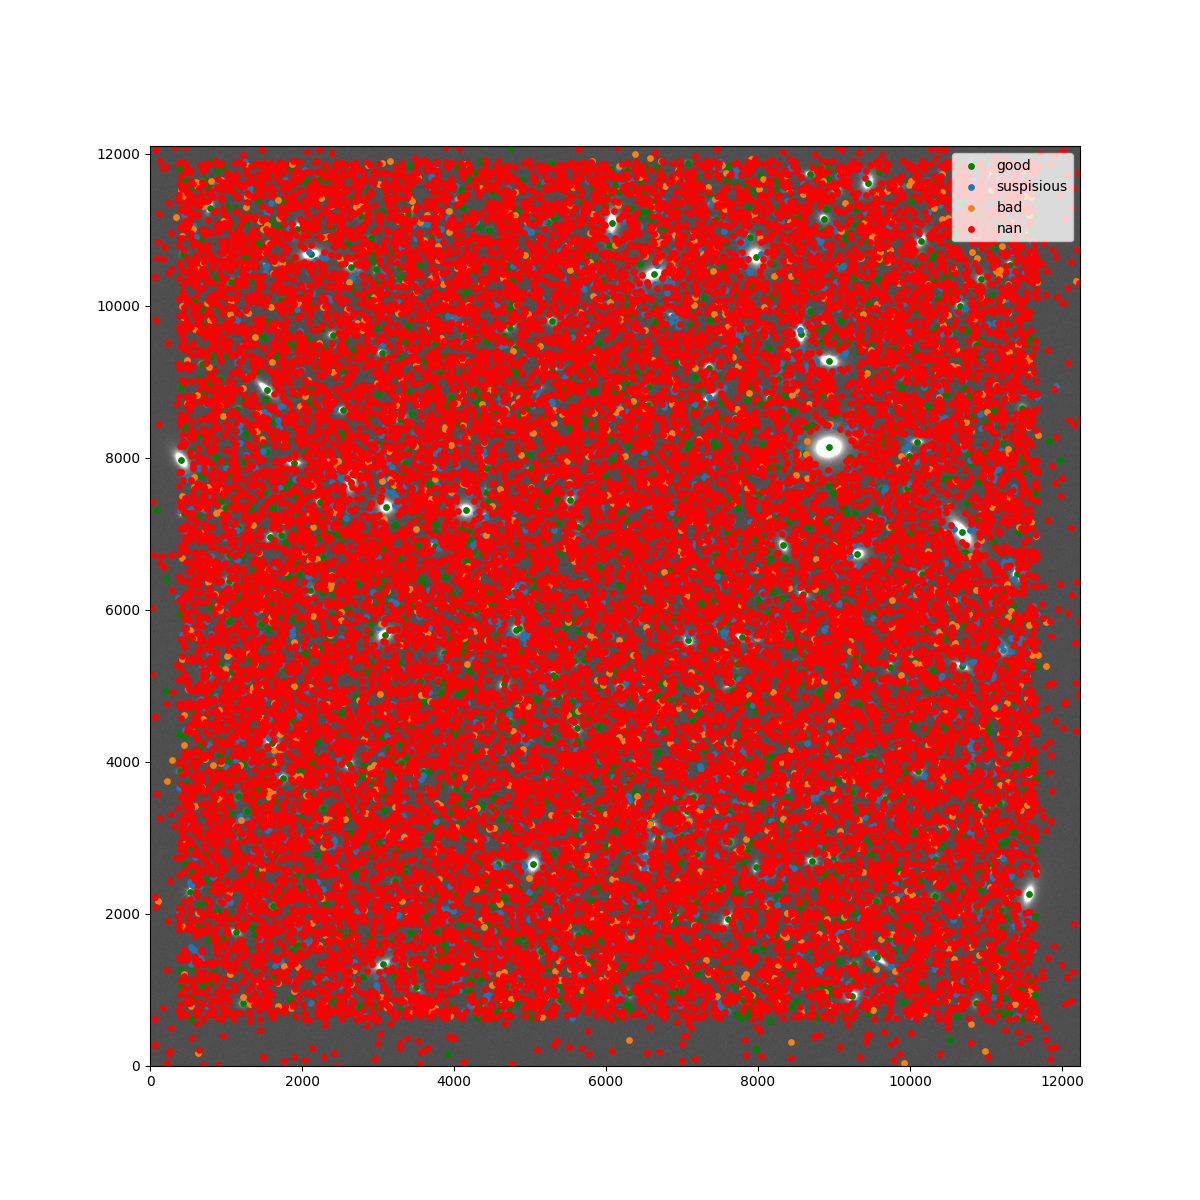

In [22]:
norm = ImageNormalize(img_bulge, interval=ZScaleInterval())
%matplotlib widget
plt.figure(figsize=(12,12))
plt.imshow(img_bulge, cmap='gray', norm=norm, origin='lower')
plt.scatter(data_bulge['X_IMAGE'][good_b]-1,data_bulge['Y_IMAGE'][good_b]-1,s=15,c='g', label='good')
plt.scatter(data_bulge['X_IMAGE'][susp_b]-1,data_bulge['Y_IMAGE'][susp_b]-1,s=15,label='suspisious')
plt.scatter(data_bulge['X_IMAGE'][bad_b]-1,data_bulge['Y_IMAGE'][bad_b]-1,s=15,label='bad')
plt.scatter(data_bulge['X_IMAGE'][nan_b]-1,data_bulge['Y_IMAGE'][nan_b]-1,s=15,c='r',label='nan')
plt.legend(loc='upper right')
plt.show()

In [23]:
%matplotlib inline

## Mag

/tmp/ipykernel_9807/725250400.py:13: RuntimeWarning: invalid value encountered in true_divide
  pg = a[0]/b[0]


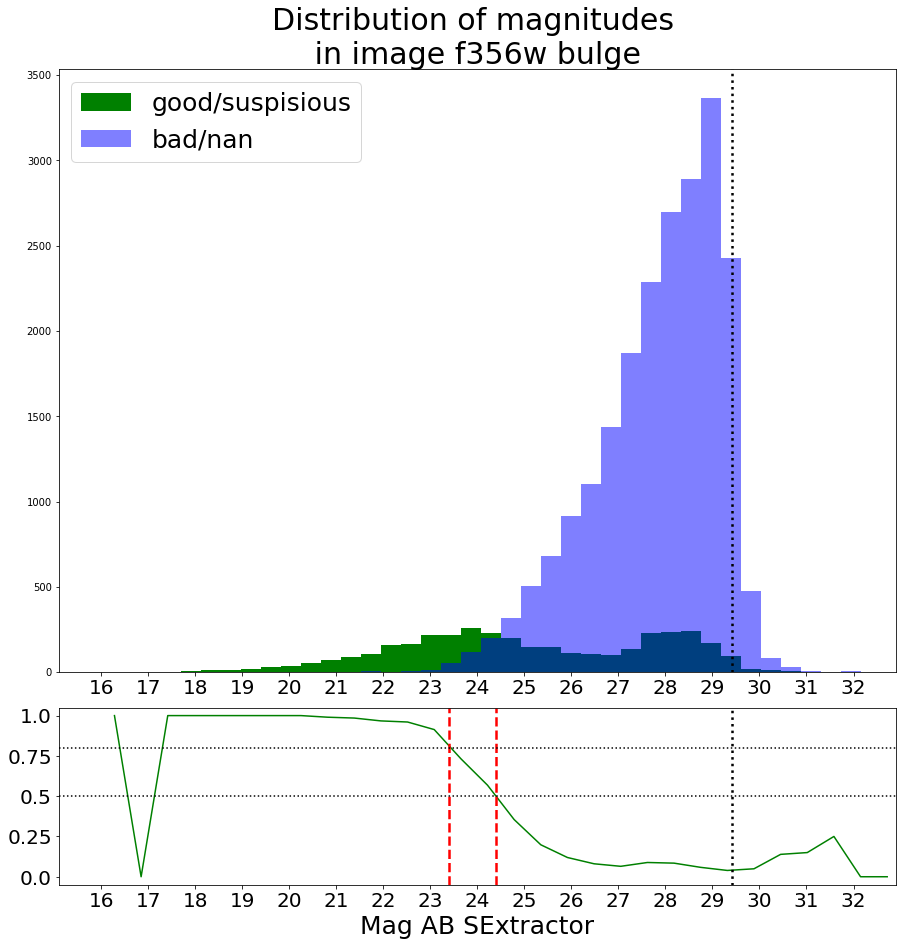

In [13]:
fig=plt.figure(figsize=(15,15))
axes=fig.subplot_mosaic(
    """
    fff
    fff
    fff
    ppp

    """)

a=np.histogram(data_bulge['MAG_BEST'][gs_b],range=(16,33),bins=30)
b=np.histogram(data_bulge['MAG_BEST'],bins=a[1])
pg = a[0]/b[0]
pg[np.isnan(pg)]=0
pos=[]
for i in range(len(a[0])):
    pos.append((a[1][i]+a[1][i+1])/2)

axes['f'].hist(data_bulge['MAG_BEST'][gs_b],range=(16,33),color='g',bins=40,label="good/suspisious",density=False)
axes['f'].hist(data_bulge['MAG_BEST'][bn_b],range=(16,33),color='b',alpha=0.5,bins=40,label='bad/nan',density=False)
axes['f'].axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
#axes['f'].axvline(x=27.7,color='r',linestyle='--', linewidth=2.5)
axes['f'].legend(fontsize=25)
axes['f'].set_xticks(np.arange(16,33,1),np.arange(16,33,1),fontsize=20)
axes['f'].set_xlim(15.1,32.9)
axes['f'].set_title("Distribution of magnitudes \n in image f356w bulge ",fontsize=30)

axes['p'].plot(pos,pg,"g")
axes['p'].axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
axes['p'].axvline(x=24.4,color='r',linestyle='--', linewidth=2.5)
axes['p'].axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)

axes['p'].axhline(y=0.8, color='k',linestyle=':', linewidth=1.5)
axes['p'].axhline(y=0.5, color='k',linestyle=':', linewidth=1.5)
axes['p'].set_xticks(np.arange(16,33,1),np.arange(16,33,1),fontsize=20)
axes['p'].set_yticks(np.arange(0,1.1,0.25),np.arange(0,1.1,0.25),fontsize=20)
axes['p'].set_xlabel("Mag AB SExtractor",fontsize=25)
axes['p'].set_xlim(15.1,32.9)

plt.show()

## In vs Out 

### cat 

In [10]:
img=fits.open("/local/home/fs269899/stage/egg_jwst/PRIMER//NIRCam/f356w/egg-20220325-jwst-f356w-sci_2_bulge_adu.fits")
img_bulge=img[0].data
header_bulge=img[0].header
w=WCS(header_bulge)

In [11]:
pixel_scale=fits.open('/local/home/fs269899/stage/jwst_psf/NIRCam/nircam_f356w_oversam.fits')[0].header['PIXELSCL']*2

In [12]:
cat = pycolfits.readfrom('/local/home/fs269899/stage/egg_jwst/PRIMER/NIRCam/f356w/egg-20220325.fits',lower_case=True)
b356=np.where(cat['bands'] == 'jwst-f356w')[0][0]
r_bulge=cat['bulge_radius'] #arcsec
r_disk=cat['disk_radius'] #arcsec
ra_deg=cat['ra'] #degree
dec_deg=cat['dec'] #degree
flux=cat['flux'][:,b356]
z=cat["z"]
m = cat["m"]
m_bulge=cat["m_bulge"]
m_disk=cat["m_disk"]
sfr=cat['sfr']
mag=-2.5*np.log10(flux)+23.9

In [13]:
ra_pix,dec_pix= w.wcs_world2pix(ra_deg,dec_deg,1)

In [14]:
mag_detect=np.where(mag<29.42)[0]

In [15]:
mag_detect.shape

(26850,)

In [16]:
cores_out_in = []
ok=[]
err_cores = []
ce = 0
error=0
for gal in trange(len(data_bulge['X_IMAGE'])):
    pos, = np.where( ( (data_bulge['X_IMAGE'][gal]-data_bulge['RE_GALFIT'][gal]) < ra_pix[mag_detect] ) & ((data_bulge['X_IMAGE'][gal]+data_bulge['RE_GALFIT'][gal]) > ra_pix[mag_detect]) & 
                  ((data_bulge['Y_IMAGE'][gal]-data_bulge['RE_GALFIT'][gal]) < dec_pix[mag_detect]) & ((data_bulge['Y_IMAGE'][gal]+data_bulge['RE_GALFIT'][gal]) > dec_pix[mag_detect]))
    
    if pos.shape[0]==1 :
        if int(pos[0]) not in cores_out_in :
            pos=np.array([pos[0]])
            ok.append(gal)
        elif int(pos[0]) in cores_out_in : 
            err_cores.append(gal)
            pos=np.array([0])
    
    elif pos.shape[0]>1 :
        ce+=1
        i=0
        while pos.shape[0]!=1 :
            pos, = np.where( ( (data_bulge['X_IMAGE'][gal]-i) < ra_pix[mag_detect] ) & ((data_bulge['X_IMAGE'][gal]+i) > ra_pix[mag_detect]) & 
                            ((data_bulge['Y_IMAGE'][gal]-i) < dec_pix[mag_detect]) & ((data_bulge['Y_IMAGE'][gal]+i) > dec_pix[mag_detect]))
            if pos.shape[0]==1 :
                if int(pos[0]) not in cores_out_in :
                    pos=np.array([pos[0]])
                    ok.append(gal)
                elif int(pos[0]) in cores_out_in : 
                    err_cores.append(gal)
                    pos=np.array([0])
            
            if i>1*data_bulge['RE_GALFIT'][gal] : #securite contre boucle infini
                error+=1
                err_cores.append(gal)
                pos=np.array([0])
            i+=0.1   
                
    elif pos.shape[0]==0 :
        ce+=1
        i=0
        while pos.shape[0]!=1 :
            pos, = np.where( ( (data_bulge['X_IMAGE'][gal]-i) < ra_pix[mag_detect] ) & ((data_bulge['X_IMAGE'][gal]+i) > ra_pix[mag_detect]) & 
                            ((data_bulge['Y_IMAGE'][gal]-i) < dec_pix[mag_detect]) & ((data_bulge['Y_IMAGE'][gal]+i) > dec_pix[mag_detect]))
            if pos.shape[0]==1 :
                if int(pos[0]) not in cores_out_in :
                    pos=np.array([pos[0]])
                    ok.append(gal)
                elif int(pos[0]) in cores_out_in : 
                    err_cores.append(gal)
                    pos=np.array([0])
            
            if i>1*data_bulge['RE_GALFIT'][gal]:
                error+=1
                err_cores.append(gal)
                pos=np.array([0])
            i+=0.1
    
    cores_out_in.append(int(pos[0]))
    
cores_out_in=np.array(cores_out_in)
print("nbr of error : ",error)

  0%|          | 0/25191 [00:00<?, ?it/s]

nbr of error :  10127


In [17]:
non_detct=np.ones(mag_detect.shape,bool)
non_detct[cores_out_in]=0

In [18]:
ngood, nsuspisious, nbad, nnon_exist = flag_results(data_bulge[ok])

In [19]:
ngs=np.concatenate((ngood,nsuspisious))
nbn=np.concatenate((nbad,nnon_exist))

### Mag 

/tmp/ipykernel_107185/4001552558.py:13: RuntimeWarning: invalid value encountered in true_divide
  pg = a[0]/b[0]


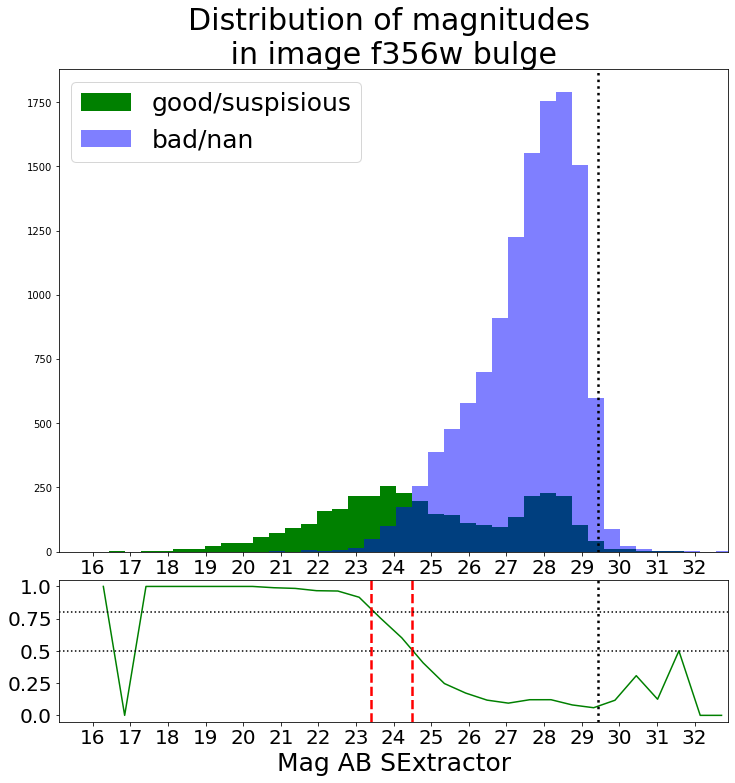

In [22]:
fig=plt.figure(figsize=(12,12))
axes=fig.subplot_mosaic(
    """
    fff
    fff
    fff
    ppp

    """)

a=np.histogram(data_bulge['MAG_BEST'][ok][ngs],range=(16,33),bins=30)
b=np.histogram(data_bulge['MAG_BEST'][ok],bins=a[1])
pg = a[0]/b[0]
pg[np.isnan(pg)]=0
pos=[]
for i in range(len(a[0])):
    pos.append((a[1][i]+a[1][i+1])/2)

axes['f'].hist(data_bulge['MAG_BEST'][ok][ngs],range=(16,33),color='g',bins=40,label="good/suspisious",density=False)
axes['f'].hist(data_bulge['MAG_BEST'][ok][nbn],range=(16,33),color='b',alpha=0.5,bins=40,label='bad/nan',density=False)
axes['f'].axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
#axes['f'].axvline(x=27.7,color='r',linestyle='--', linewidth=2.5)
axes['f'].legend(fontsize=25)
axes['f'].set_xticks(np.arange(16,33,1),np.arange(16,33,1),fontsize=20)
axes['f'].set_xlim(15.1,32.9)
axes['f'].set_title("Distribution of magnitudes \n in image f356w bulge ",fontsize=30)

axes['p'].plot(pos,pg,"g")
axes['p'].axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
axes['p'].axvline(x=24.5,color='r',linestyle='--', linewidth=2.5)
axes['p'].axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)

axes['p'].axhline(y=0.8, color='k',linestyle=':', linewidth=1.5)
axes['p'].axhline(y=0.5, color='k',linestyle=':', linewidth=1.5)
axes['p'].set_xticks(np.arange(16,33,1),np.arange(16,33,1),fontsize=20)
axes['p'].set_yticks(np.arange(0,1.1,0.25),np.arange(0,1.1,0.25),fontsize=20)
axes['p'].set_xlabel("Mag AB SExtractor",fontsize=25)
axes['p'].set_xlim(15.1,32.9)

plt.show()

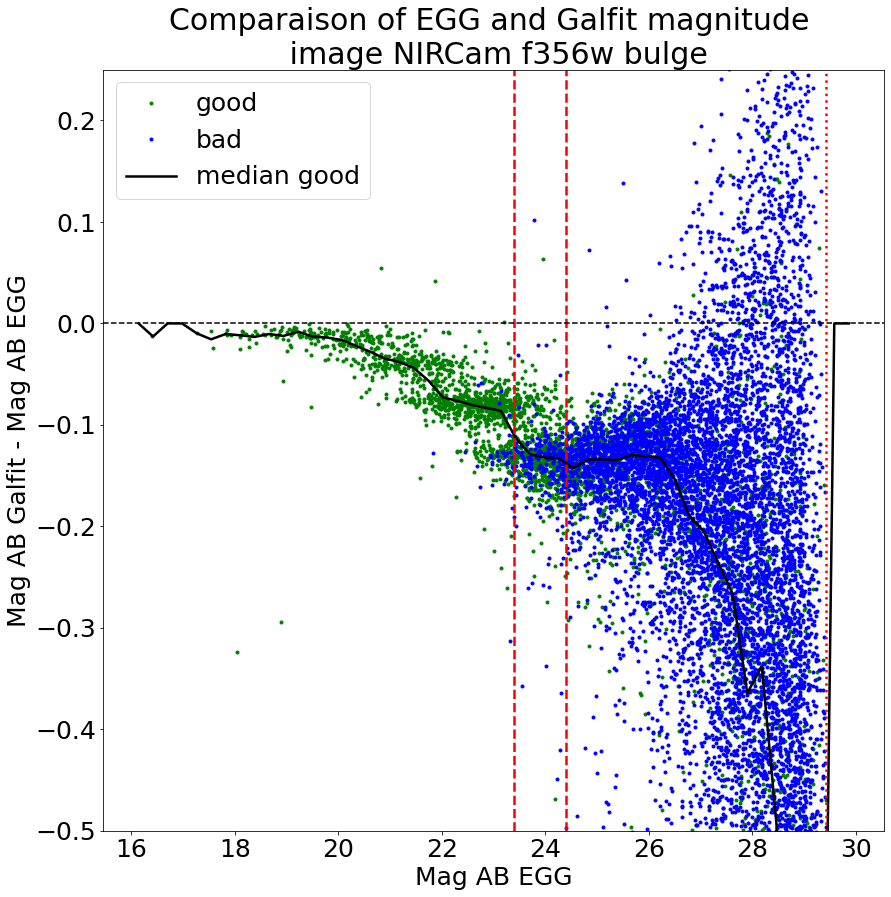

In [23]:
re = []
low_err, high_err = [],[]
mag_re=[]

bx=50

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    #dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in[ok]][f[i]]>minx) & (mag[mag_detect][cores_out_in[ok]][f[i]]<maxx))
        
        if len(data_bulge['MAG_GALFIT'][ok][f[i]][m_index]-mag[mag_detect][cores_out_in[ok]][f[i]][m_index]) >=1 :
            r.append(np.median(((data_bulge['MAG_GALFIT'][ok][f[i]][m_index]-mag[mag_detect][cores_out_in[ok]][f[i]][m_index]))))
        else :
            r.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)

    
    mag_re.append(ml)

plt.figure(figsize=(14,14))

plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],data_bulge['MAG_GALFIT'][ok][ngs]-mag[mag_detect][cores_out_in[ok]][ngs],"g.",label="good")
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],data_bulge['MAG_GALFIT'][ok][nbn]-mag[mag_detect][cores_out_in[ok]][nbn],"b.",label="bad")
plt.plot(mag_re[0],re[0],"k-",label="median good", linewidth=2.5)

plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=24.4,color='r',linestyle='--', linewidth=2.5)
plt.axhline(y=0,color='k',linestyle='--', linewidth=1.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Mag AB Galfit - Mag AB EGG', fontsize=25)
plt.title("Comparaison of EGG and Galfit magnitude \n image NIRCam f356w bulge",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim(-0.5,0.25)
plt.legend(fontsize=25)
plt.show()

In [27]:
%matplotlib inline

### Sersic 

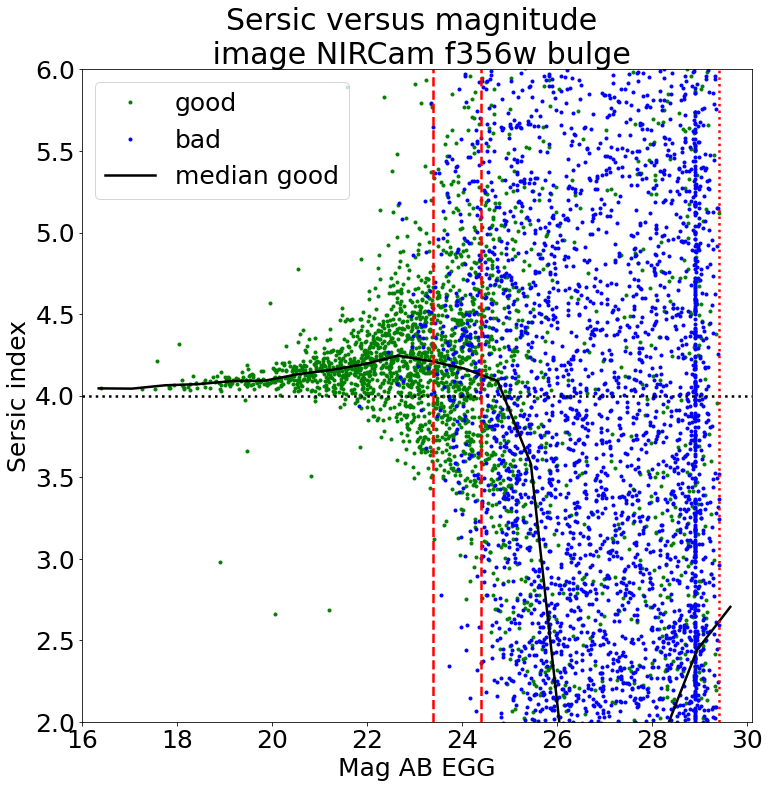

In [26]:
%matplotlib inline

sersic = []
mag_s=[]

bx=20

for j in range(bx) :
    
    minx= int(mag[mag_detect][cores_out_in[ok]][ngs].min())+( int(mag[mag_detect][cores_out_in[ok]][ngs].max()+1)-int(mag[mag_detect][cores_out_in[ok]][ngs].min())  )/bx*j
    maxx= int(mag[mag_detect][cores_out_in[ok]][ngs].min())+( int(mag[mag_detect][cores_out_in[ok]][ngs].max()+1)-int(mag[mag_detect][cores_out_in[ok]][ngs].min())  )/bx*(j+1)
    
    m_index,=np.where((mag[mag_detect][cores_out_in[ok]][ngs]>minx) & (mag[mag_detect][cores_out_in[ok]][ngs]<maxx))
    
    if data_bulge['SERSIC_GALFIT'][ok][ngs][m_index].shape[0]>=1 : 
        sersic.append(np.median(data_bulge['SERSIC_GALFIT'][ok][ngs][m_index]))
        
    else :
        sersic.append(0)
        
    mag_s.append((minx+maxx)/2)

plt.figure(figsize=(12,12))
plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],data_bulge['SERSIC_GALFIT'][ok][ngs],'g.',label='good')
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],data_bulge['SERSIC_GALFIT'][ok][nbn],'b.',label='bad')

plt.plot(mag_s,sersic,'k',label="median good", linewidth=2.5)

plt.axhline(y=4,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=29.42,color='r',linestyle=':', linewidth=2.5)
plt.axvline(x=24.4,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)

plt.xlabel('Mag AB EGG',fontsize=25)
plt.ylabel('Sersic index', fontsize=25)
plt.title('Sersic versus magnitude \n image NIRCam f356w bulge', fontsize=30)
plt.xlim(16,30.1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.ylim(2,6)
plt.show()

### Re 

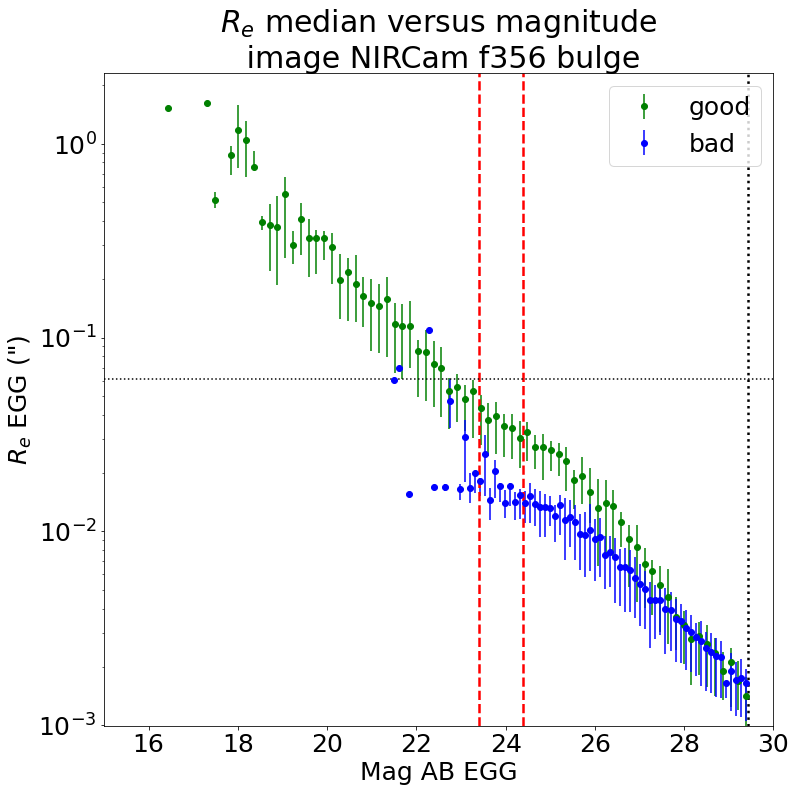

In [25]:
%matplotlib inline
re = []
low_err, high_err = [],[]
mag_re=[]

bx=80

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    dl,dh=[],[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in][ok][f[i]].min())+( int(mag[mag_detect][cores_out_in][ok][f[i]].max()+1)-int(mag[mag_detect][cores_out_in][ok][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in][ok][f[i]].min())+( int(mag[mag_detect][cores_out_in][ok][f[i]].max()+1)-int(mag[mag_detect][cores_out_in][ok][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in][ok][f[i]]>minx) & (mag[mag_detect][cores_out_in][ok][f[i]]<maxx))
        
        if len(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index]) >=1 :
            r.append(np.mean(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index]))
            dl.append(abs(np.mean(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index])-np.quantile(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index],0.25)))
            dh.append(abs(np.mean(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index])-np.quantile(r_bulge[mag_detect][cores_out_in][ok][f[i]][m_index],0.75)))
        else :
            r.append(0)
            dl.append(0)
            dh.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)
    
    low_err.append(dl)
    high_err.append(dh)
    
    mag_re.append(ml)

errg = [low_err[0],high_err[0]]
errs = [low_err[1],high_err[1]]
plt.figure(figsize=(12,12))
plt.errorbar(mag_re[0],re[0],yerr=errg,fmt="go",label="good")
plt.errorbar(mag_re[1],re[1],yerr=errs,fmt="bo",label="bad")
plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=24.4,color='r',linestyle='--', linewidth=2.5)

fwhm = 3.56/6e6/np.pi*180*3600
plt.axhline(y=fwhm/2,color='k',linestyle=':')
plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'$R_e$ EGG (")', fontsize=25)
plt.title(r'$R_e$ median versus magnitude' + '\n image NIRCam f356 bulge', fontsize=30)
plt.xlim(15,30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper right',fontsize=25)
#plt.ylim(5e-2,7e-1)
#plt.ylim(0,0.5)
plt.semilogy()
plt.show()

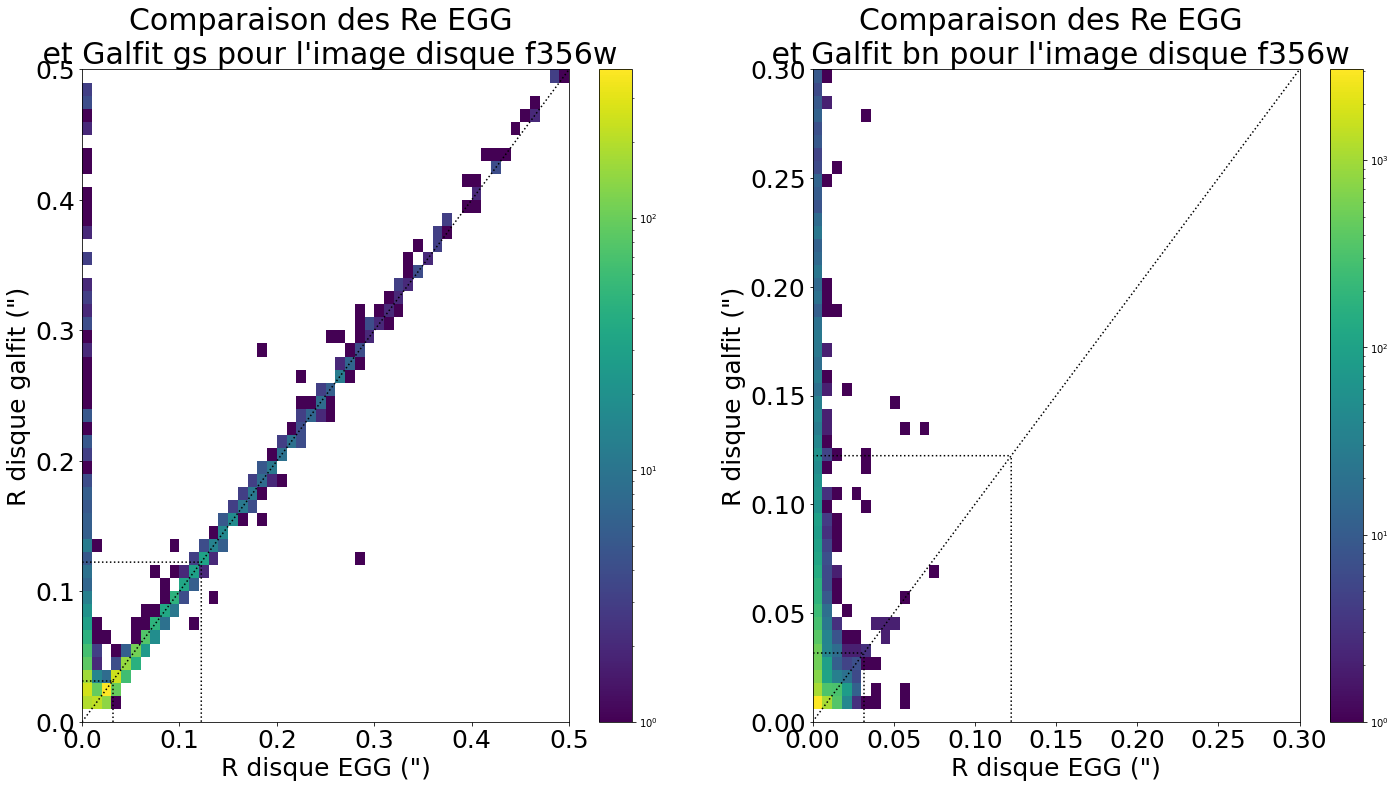

In [24]:
%matplotlib inline
plt.figure(figsize=(24,12))

plt.subplot(121)
plt.hist2d(r_bulge[mag_detect][cores_out_in[ok]][ngs],data_bulge['RE_GALFIT'][ok][ngs]*pixel_scale,range=[[0, 0.5], [0, 0.5]],bins=50,norm=LogNorm())
plt.plot(np.arange(0,4,3),np.arange(0,4,3),"k:")
plt.xlabel('R disque EGG (")',fontsize=25)
plt.ylabel('R disque galfit (")', fontsize=25)
plt.title("Comparaison des Re EGG \n et Galfit gs pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.colorbar()

fw=3.56/6e6/np.pi*180*3600
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

fw=pixel_scale
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

plt.subplot(122)
plt.hist2d(r_bulge[mag_detect][cores_out_in[ok]][nbn],data_bulge['RE_GALFIT'][ok][nbn]*pixel_scale,range=[[0, 0.3], [0, 0.3]],bins=50,norm=LogNorm())
plt.plot(np.arange(0,4,3),np.arange(0,4,3),"k:")
plt.xlabel('R disque EGG (")',fontsize=25)
plt.ylabel('R disque galfit (")', fontsize=25)
plt.title("Comparaison des Re EGG \n et Galfit bn pour l'image disque f356w",fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.colorbar()

fw=3.56/6e6/np.pi*180*3600
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

fw=pixel_scale
fw_x=np.arange(0,fw,0.0001)
plt.plot(np.ones(fw_x.shape[0])*fw,fw_x,'k:')
plt.plot(fw_x,np.ones(fw_x.shape[0])*fw,'k:')

plt.show()

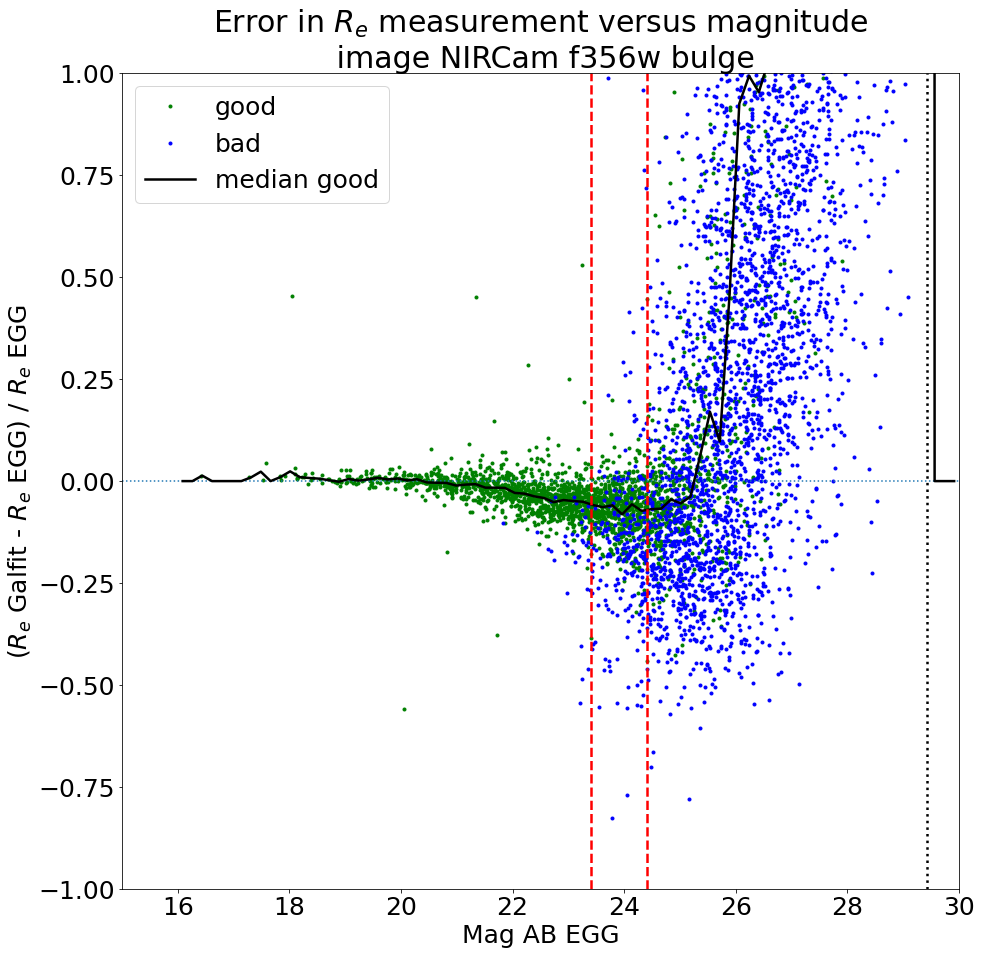

In [25]:
%matplotlib inline

re = []
mag_re=[]

bx=80

f=[ngs,nbn]

for i in range(len(f)):
    # pour traitement dans for suivant
    r=[]
    ml=[]
    
    for j in range(bx) :
        
        minx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*j
        maxx= int(mag[mag_detect][cores_out_in[ok]][f[i]].min())+( int(mag[mag_detect][cores_out_in[ok]][f[i]].max()+1)-int(mag[mag_detect][cores_out_in[ok]][f[i]].min())  )/bx*(j+1)
    
        m_index,=np.where((mag[mag_detect][cores_out_in[ok]][f[i]]>minx) & (mag[mag_detect][cores_out_in[ok]][f[i]]<maxx))
        
        if len(r_bulge[mag_detect][cores_out_in[ok]][f[i]][m_index]) >=1 :
            r.append(np.median((data_bulge['RE_GALFIT'][ok][f[i]][m_index]*pixel_scale-r_bulge[mag_detect][cores_out_in[ok]][f[i]][m_index])/(r_bulge[mag_detect][cores_out_in[ok]][f[i]][m_index])))
        else :
            r.append(0)
        ml.append((minx+maxx)/2)
    
    re.append(r)
    mag_re.append(ml)

p_re = (data_bulge['RE_GALFIT'][ok][ngs]*pixel_scale-r_bulge[mag_detect][cores_out_in[ok]][ngs])/(r_bulge[mag_detect][cores_out_in[ok]][ngs])
p_re_bn = (data_bulge['RE_GALFIT'][ok][nbn]*pixel_scale-r_bulge[mag_detect][cores_out_in[ok]][nbn])/(r_bulge[mag_detect][cores_out_in[ok]][nbn])
plt.figure(figsize=(15,15))

plt.plot(mag[mag_detect][cores_out_in[ok]][ngs],p_re,'g.',label='good')
plt.plot(mag[mag_detect][cores_out_in[ok]][nbn],p_re_bn,'b.',label='bad')
plt.plot(np.arange(15,35,3),np.zeros(np.arange(15,35,3).shape[0]),":")
plt.plot(mag_re[0],re[0],"k-",label="median good", linewidth=2.5)

plt.axvline(x=29.42,color='k',linestyle=':', linewidth=2.5)
plt.axvline(x=23.4,color='r',linestyle='--', linewidth=2.5)
plt.axvline(x=24.4,color='r',linestyle='--', linewidth=2.5)

plt.xlabel(r'Mag AB EGG',fontsize=25)
plt.ylabel(r'($R_e$ Galfit - $R_e$ EGG) / $R_e$ EGG', fontsize=25)
plt.title( r'Error in $R_e$ measurement versus magnitude' + '\n image NIRCam f356w bulge', fontsize=30)
plt.xlim(15,30)
plt.ylim(-1,1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

### SFR 

In [21]:
bx=60 #bin x
by=60 #bin y
zb=[0,0.5,1,1.5,2.5,3.5,15]

imgz=[]
t = []
g = []

for k in trange(len(zb)-1):

    img=[]
    
    tot=np.zeros((bx,by))
    ntg=np.zeros((bx,by))

    for i in range(by) : 
        l=[]
        
        
        
        for j in range(bx) :
            zl = np.where((z[mag_detect]>zb[k])&(z[mag_detect]<zb[k+1]))[0]
            minx= int(m[mag_detect][zl].min())+( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/bx*j
            maxx= int(m[mag_detect][zl].min())+( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/bx*(j+1)
            miny= int(np.log10(sfr[mag_detect][zl]).min()-1)+( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1 ) )/by*i
            maxy= int(np.log10(sfr[mag_detect][zl]).min()-1)+( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1) )/by*(i+1)
            
            
            nt = np.where( (m[mag_detect][zl]>minx) & (m[mag_detect][zl]<maxx) & (np.log10(sfr[mag_detect][zl]) > miny) & (np.log10(sfr[mag_detect][zl]) < maxy) )[0].shape[0]
            
            tot[i][j]=nt

            if nt ==0 :
                l.append([1.,1.,1.])
                
            else:
                
                zl = np.where((z[mag_detect][cores_out_in][gs_b]>zb[k])&(z[mag_detect][cores_out_in][gs_b]<zb[k+1]))[0]
                ngs_b = np.where( (m[mag_detect][cores_out_in][gs_b][zl]>minx) & (m[mag_detect][cores_out_in][gs_b][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][gs_b][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][gs_b][zl]) < maxy) )[0].shape[0]/nt
                
                ntg[i][j]=np.where( (m[mag_detect][cores_out_in][gs_b][zl]>minx) & (m[mag_detect][cores_out_in][gs_b][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][gs_b][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][gs_b][zl]) < maxy) )[0].shape[0]
                
                zl = np.where((z[mag_detect][cores_out_in][bn_b]>zb[k])&(z[mag_detect][cores_out_in][bn_b]<zb[k+1]))[0]
                nbn_b = np.where( (m[mag_detect][cores_out_in][bn_b][zl]>minx) & (m[mag_detect][cores_out_in][bn_b][zl]<maxx) & 
                               (np.log10(sfr[mag_detect][cores_out_in][bn_b][zl]) > miny) & (np.log10(sfr[mag_detect][cores_out_in][bn_b][zl]) < maxy) )[0].shape[0]/nt
                
                zl = np.where((z[mag_detect][non_detct]>zb[k])&(z[mag_detect][non_detct]<zb[k+1]))[0]
                nnf = np.where( (m[mag_detect][non_detct][zl]>minx) & (m[mag_detect][non_detct][zl]<maxx) & 
                                (np.log10(sfr[mag_detect][non_detct][zl]) > miny) & (np.log10(sfr[mag_detect][non_detct][zl]) < maxy) )[0].shape[0]/nt
                l.append([nnf,ngs_b,nbn_b])
                
                

        img.append(l)
    t.append(tot)
    g.append(ntg)
    imgz.append(img)

  0%|          | 0/6 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


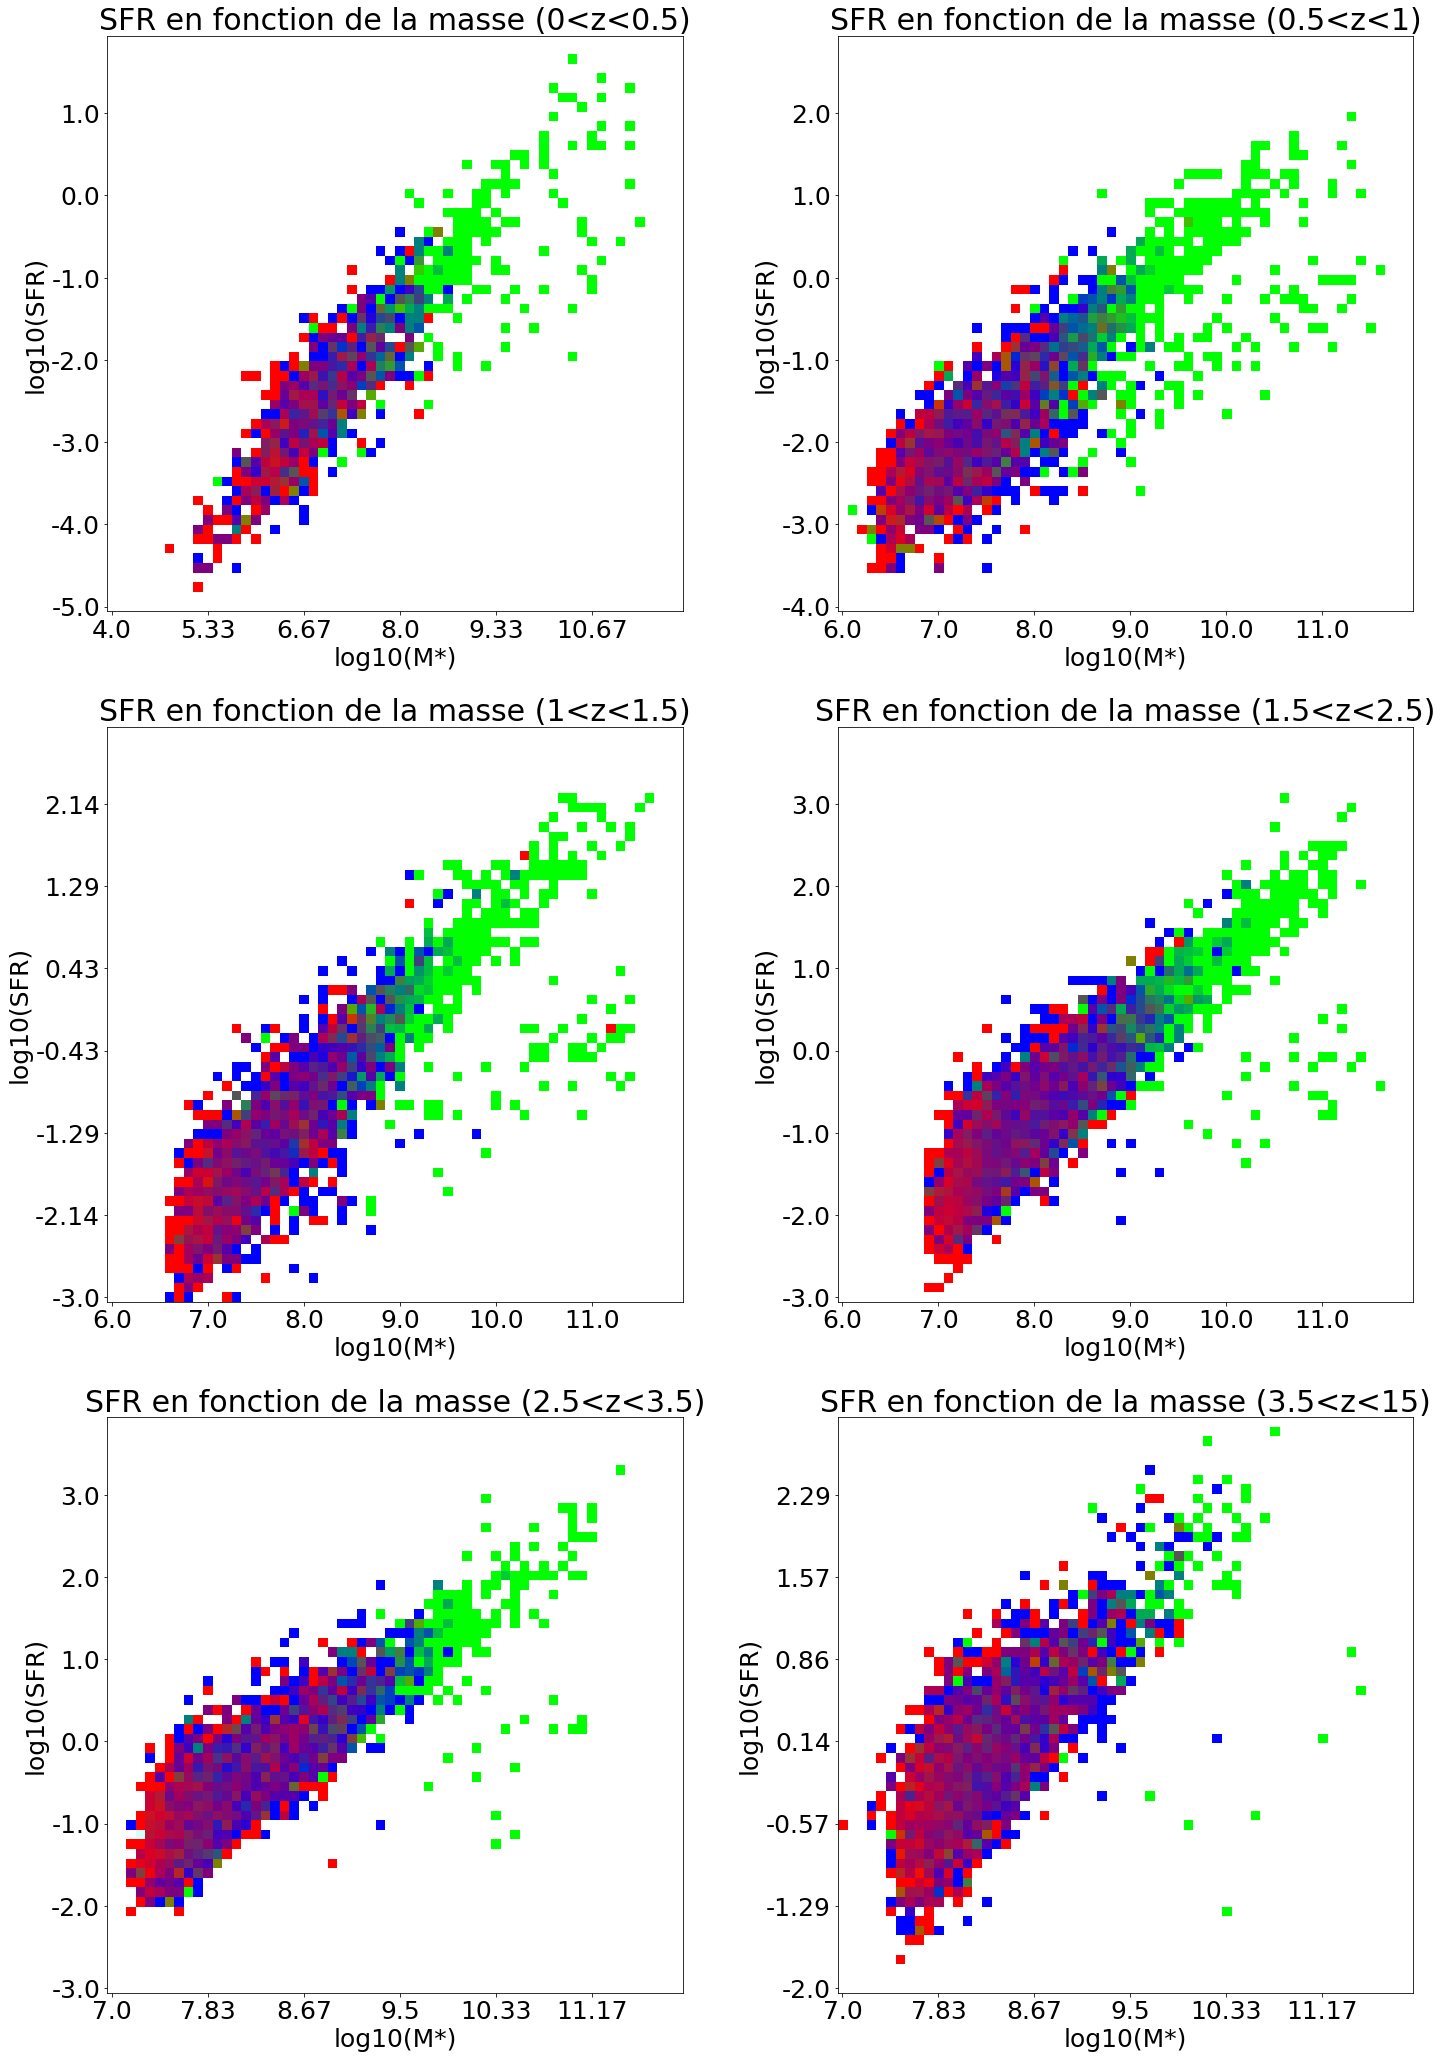

In [25]:
%matplotlib inline


plt.figure(figsize=(24,36))

for i in range(len(zb)-1):
    plt.subplot(3,2,i+1)
    plt.imshow(imgz[i],origin='lower')
    
    plt.title("SFR en fonction de la masse ({}<z<{})".format(zb[i],zb[i+1]),fontsize=30)
    
    zl = np.where((z[mag_detect]>zb[i])&(z[mag_detect]<zb[i+1]))[0]
    ntx = 6
    nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
    lx=np.around(np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/ntx),decimals=2)

    nty = 7
    ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
    ly=np.around(np.arange(int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1),( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1)  )/nty),decimals=2)

    plt.xlabel('log10(M*)',fontsize=25)
    plt.ylabel('log10(SFR)', fontsize=25)
    plt.xticks(nx,lx,fontsize=25)
    plt.yticks(ny,ly,fontsize=25)
#plt.colorbar()
plt.show()

/tmp/ipykernel_40144/3170029710.py:14: RuntimeWarning: invalid value encountered in true_divide
  sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
/tmp/ipykernel_40144/3170029710.py:18: RuntimeWarning: invalid value encountered in true_divide
  mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)


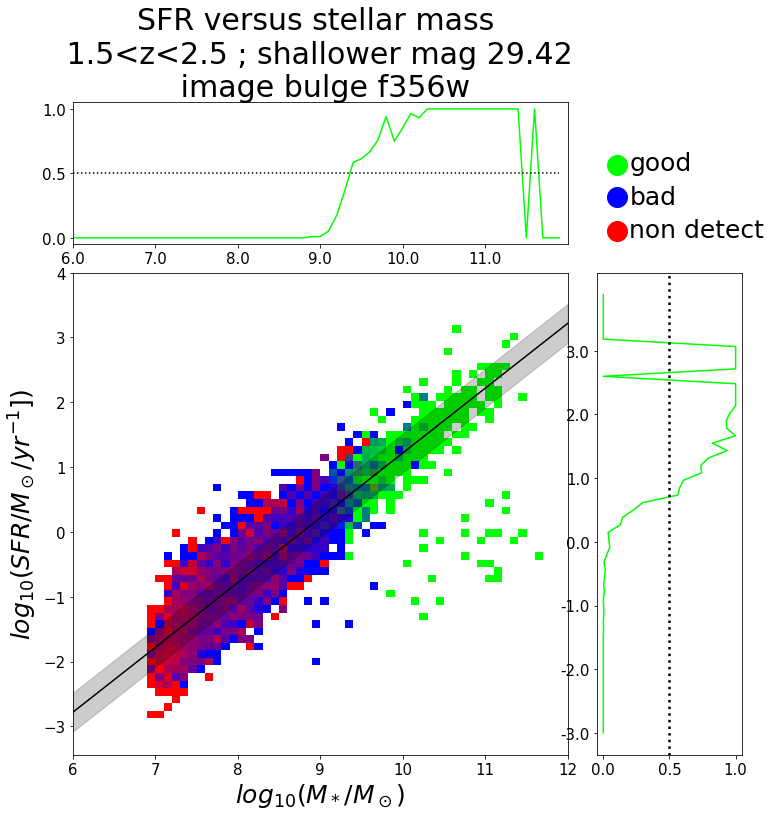

In [26]:
%matplotlib inline
i=3

zl = np.where((z[mag_detect]>zb[i])&(z[mag_detect]<zb[i+1]))[0]
ntx = 6
nx=np.arange(0,np.array(img).shape[0],np.array(img).shape[0]/ntx)
lx=np.around(np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),( int(m[mag_detect][zl].max()+1)-int(m[mag_detect][zl].min())  )/ntx),decimals=2)

nty = 7
ny=np.arange(0,np.array(img).shape[1],np.array(img).shape[0]/nty)
ly=np.around(np.arange(int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1),( int(np.log10(sfr[mag_detect][zl]).max()+1)-int(np.log10(sfr[mag_detect][zl]).min()-1)  )/nty),decimals=2)


sfrg=np.sum(g[i],axis=0)/np.sum(t[i],axis=0)
sfrg[np.isnan(sfrg)]=0
x=np.arange(sfrg.shape[0])

mg=np.sum(g[i],axis=1)/np.sum(t[i],axis=1)
mg[np.isnan(mg)]=0
y=np.arange(mg.shape[0])

xMS = np.arange(int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1)+0.1,0.1)
logzMS = np.log10(1+(zb[i]+zb[i+1])/2)
yMS=xMS-9.5+1.5*logzMS-0.3*(max(0,xMS.any()-9.36-2.5*logzMS))**2



fig=plt.figure(figsize=(12,12))
axes=fig.subplot_mosaic(
    """
    aaal
    bbbc
    bbbc
    bbbc
    """)

axes['a'].set_title("SFR versus stellar mass \n {}<z<{} ; shallower mag 29.42 \n image bulge f356w".format(zb[i],zb[i+1]),fontsize=30)

axes['a'].plot(x,sfrg,color=(0,1,0))
axes['a'].plot(x,np.ones(x.shape[0])*0.5,'k:')
axes['a'].set_xticks(nx,lx,fontsize=15)
axes['a'].set_xlim(0,sfrg.shape[0])
axes['a'].tick_params(axis='y', labelsize= 15)

axes['c'].plot(mg,y,color=(0,1,0))
axes['c'].set_yticks(ny,ly,fontsize=15)
axes['c'].axvline(x=0.5,color='k',linestyle=':', linewidth=2.5)
axes['c'].tick_params(axis='x', labelsize= 15)

axes['b'].imshow(imgz[i],origin='lower',
                extent=[int(m[mag_detect][zl].min()),int(m[mag_detect][zl].max()+1),int(np.log10(sfr[mag_detect][zl]).min()-1),int(np.log10(sfr[mag_detect][zl]).max()+1)],aspect='auto')
axes['b'].set_xlabel(r'$log_{10}(M_*/M_\odot)$',fontsize=25)
axes['b'].set_ylabel(r'$log_{10}(SFR/M_\odot/yr^{-1}])$', fontsize=25)
axes['b'].tick_params(axis='x', labelsize= 15)
axes['b'].tick_params(axis='y', labelsize= 15)
axes['b'].plot(xMS,yMS,'k-')
axes['b'].fill_between(xMS,yMS-0.3,yMS+0.3,color='k',alpha=0.2)

axes['l'].plot(0,2.15,'o',color=(0,1,0),ms=20,label='good')
axes['l'].plot(0,1.2,'bo',ms=20,label='bad')
axes['l'].plot(0,0.2,'ro',ms=20,label='non detect')
axes['l'].set_xlim(-0.008,0.05)
axes['l'].set_ylim(-0.2,4)
axes['l'].text(0.005,2,"good",fontsize=25)
axes['l'].text(0.005,1,"bad",fontsize=25)
axes['l'].text(0.005,0,"non detect",fontsize=25)
axes['l'].axis('off')

plt.show()